# Dynamic yield curve modelling examples
## Install requirements

In [1]:
system("sudo apt-get install libmpfr-dev") # Rmpfr dependency

# For ahead
options(repos = c(techtonique = "https://techtonique.r-universe.dev", CRAN = "https://cloud.r-project.org"))

# Packages' target
system("mkdir -p ./mysitepackages/R")
.libPaths("./mysitepackages/R")

# Check and install required packages
options(warn = -1)
pckgs <- c(
  "dplyr", "magrittr", "data.table", "ggplot2", "ggdist", "Rmpfr", "Bessel", "rmgarch", "misc", "VineCopula", "ahead"
)
for (p in pckgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, lib = "./mysitepackages/R")
    library(p, character.only = TRUE, lib.loc = "./mysitepackages/R")
  } else {
    library(p, character.only = TRUE)
  }
}

options(warn = -1)

# Set options for Jupyter Notebook
options("jupyter.plot_scale" = 1.5)
options(repr.plot.width = 10, repr.plot.height = 7)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: gmp


Attaching package: ‘gmp’


The following objects are masked from ‘package:base’:

    %*%, apply, crossprod, matrix, tcrossprod


C code of R package 'Rmpfr': GMP using 64 bits per limb



Attaching package: ‘Rmpfr’


The following object is masked from ‘package:gmp’:

    outer


The following objects are masked from ‘package:stats’:

    dbinom, dgamma, dnbinom, dnorm, dpois, dt, pnorm


The following objects are masked from ‘package:base’:

    cbind, pmax, pmin, rbind


Loading required package: rugarch

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma





# Vector Autoregressive models
## Load data

In [2]:
load("../input/yield-curve-modeling-nelson-siegel-svensson/myworkspace.RData")
#load("/kaggle/input/yield-curve-factor-forecasting-var-in-r/results.RData")

mybetas_joint_diff <- mybetas_joint |> diff()

## Fitting $VAR(p=1)$ model

In [3]:
varmodel <- tsDyn::lineVar(mybetas_joint_diff, lag = 1, include = "none", model = "VAR", I = "level")

In [4]:
rolls <- varmodel |> tsDyn::predict_rolling(nroll = 36, n.ahead = 1, refit.every = 12, newdata = mybetas_joint_diff)
rownames(rolls$pred) <- rownames(rolls$true)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘rlang’


The following object is masked from ‘package:ggdist’:

    ll


The following object is masked from ‘package:data.table’:

    :=


The following object is masked from ‘package:magrittr’:

    set_names




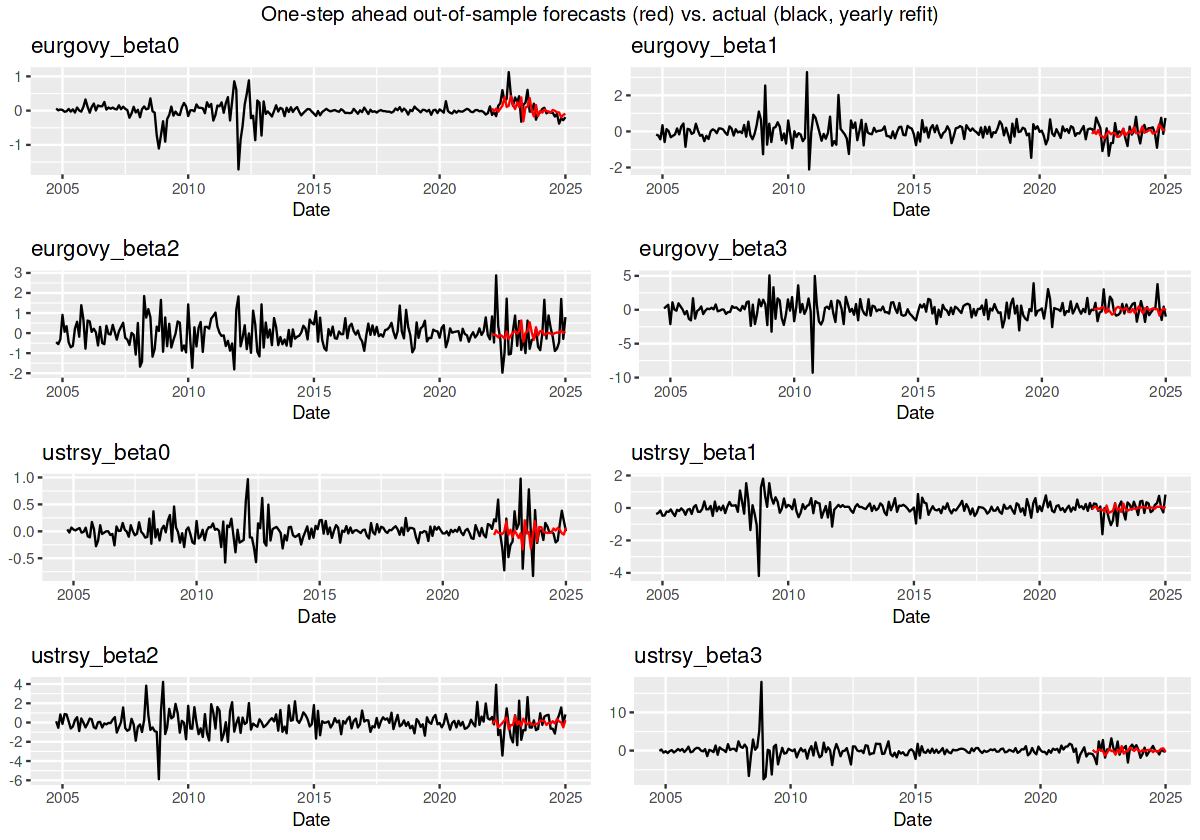

In [5]:
library(gridExtra)
library(rlang)

# Convert xts object to data frame
data_df <- as_tibble(mybetas_joint_diff, rownames = "Date") |> mutate(Date = as.Date(Date))
rolls_df <- as_tibble(rolls$pred, rownames = "Date")|> mutate(Date = as.Date(Date))

# Create and store plots in a list
plot_list <- lapply(1:8, function(i) {
  col_name <- colnames(data_df)[i + 1] # Adjust for Date column
  ggplot(data_df, aes(x = Date, y = !!sym(col_name), group = 1)) + # Ensure grouping is correct
    geom_line() +
    geom_line(data = rolls_df, aes(x = Date, y = !!sym(col_name), group = 1), color = "red") + 
    ylab(NULL) +
    ggtitle(col_name)
})

# Arrange the plots in a 4x2 grid
grid.arrange(grobs = plot_list, ncol = 2, nrow = 4, top = "One-step ahead out-of-sample forecasts (red) vs. actual (black, yearly refit)")

### Diagnostic plots

In [6]:
# Define plot functions
plot_fitted_vs_residuals <- function(fitted, residuals, selected = 1:8, mfrow = c(2, 4)){
    opar <- par(no.readonly = TRUE)
    par(mfrow = mfrow)
    for(i in selected)plot.default(fitted[, i], residuals[, i], 
                                   xlab = colnames(fitted)[i],
                                   ylab = "Residuals"
                                  )
    mtext("Fitted vs. residuals", outer = TRUE, cex = 1.5, line = -2.5, font = 2)
    par(opar)
}

plot_residuals <- function(residuals, title = "Residuals"){
    opar <- par(no.readonly = TRUE)
    par(mfrow = c(ncol(residuals)%/%2, 2))
    for(i in seq.int(ncol(residuals))){
        plot.default(seq.int(nrow(residuals)), residuals[, i], type = "l", 
                     xlab = colnames(residuals)[i], ylab = "Value")
    }
    mtext(title, outer = TRUE, cex = 1.5, line = -2.5, font = 2)
    par(opar)
    }


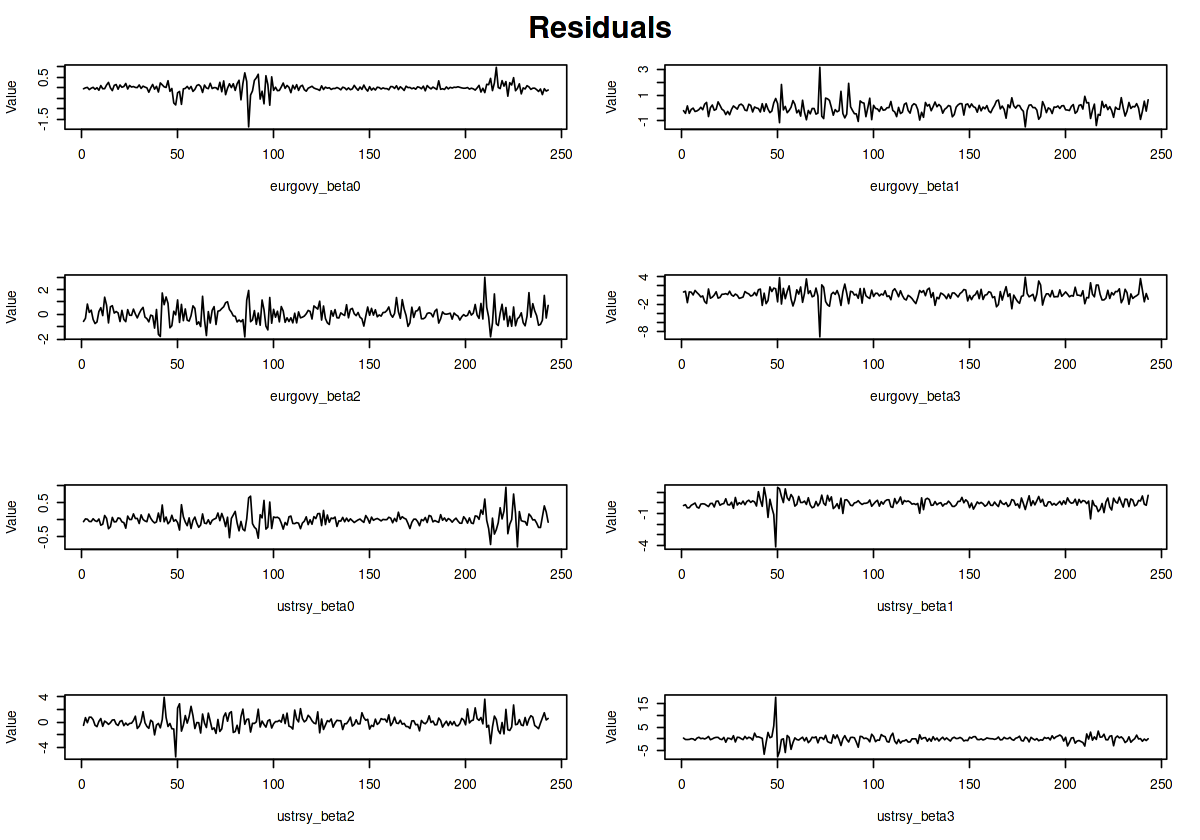

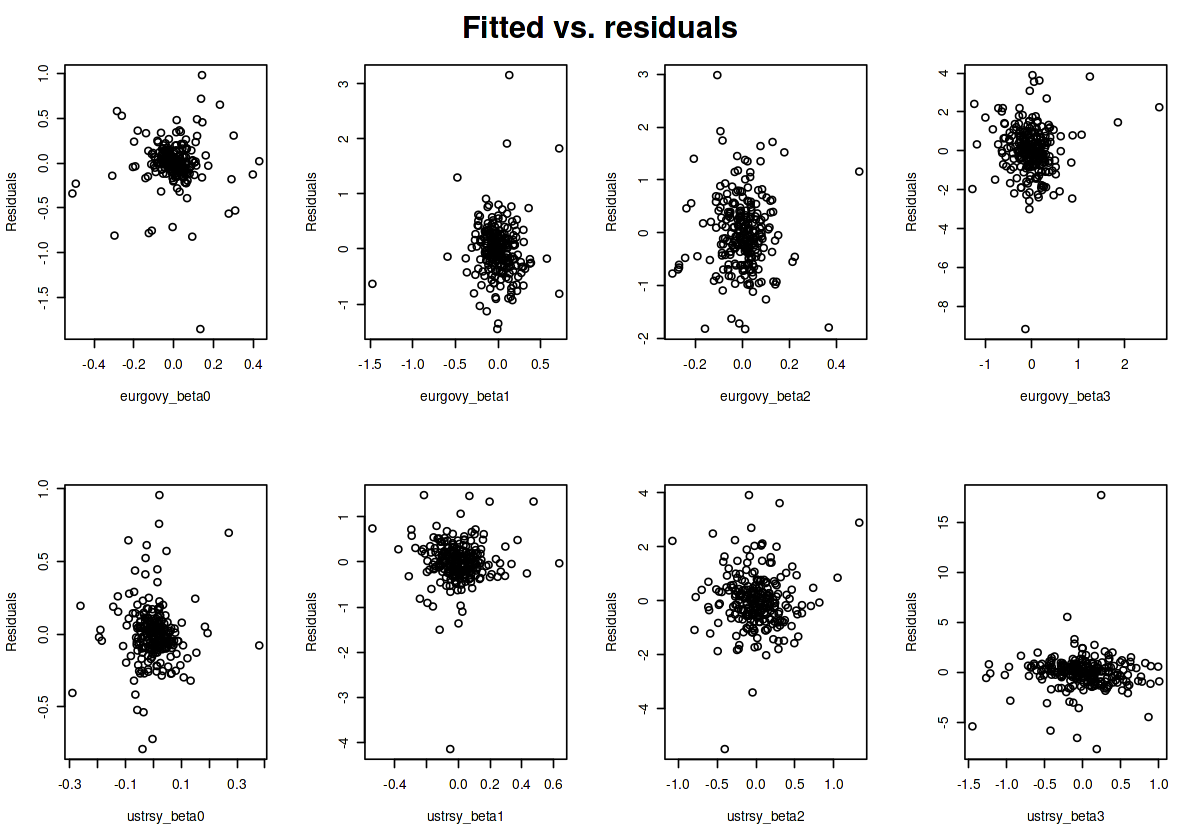

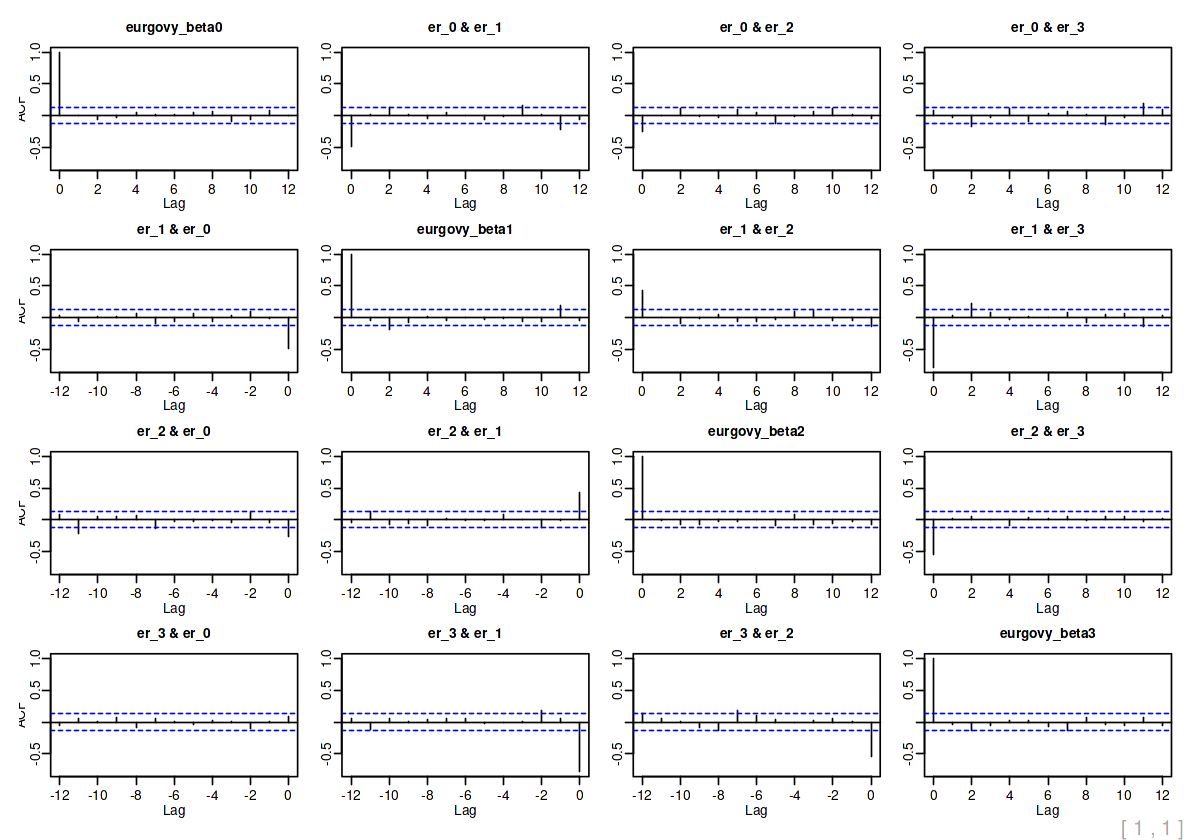

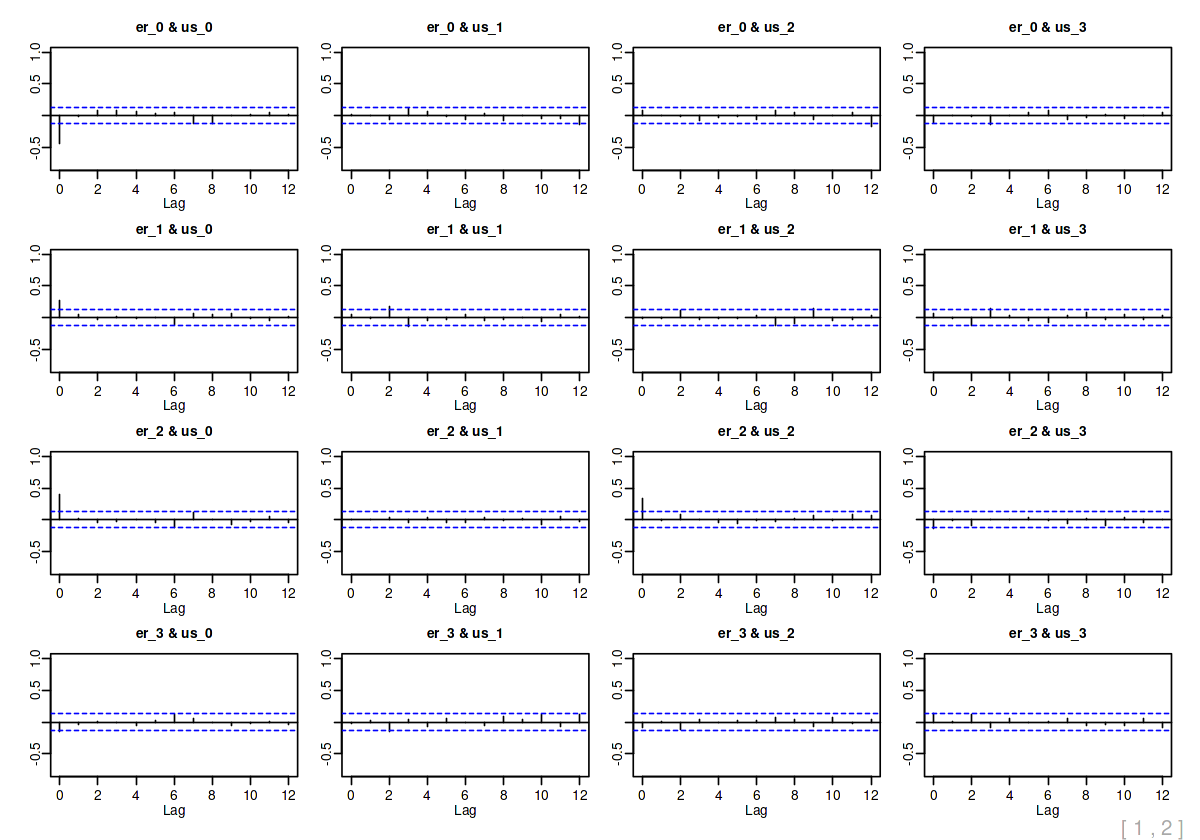

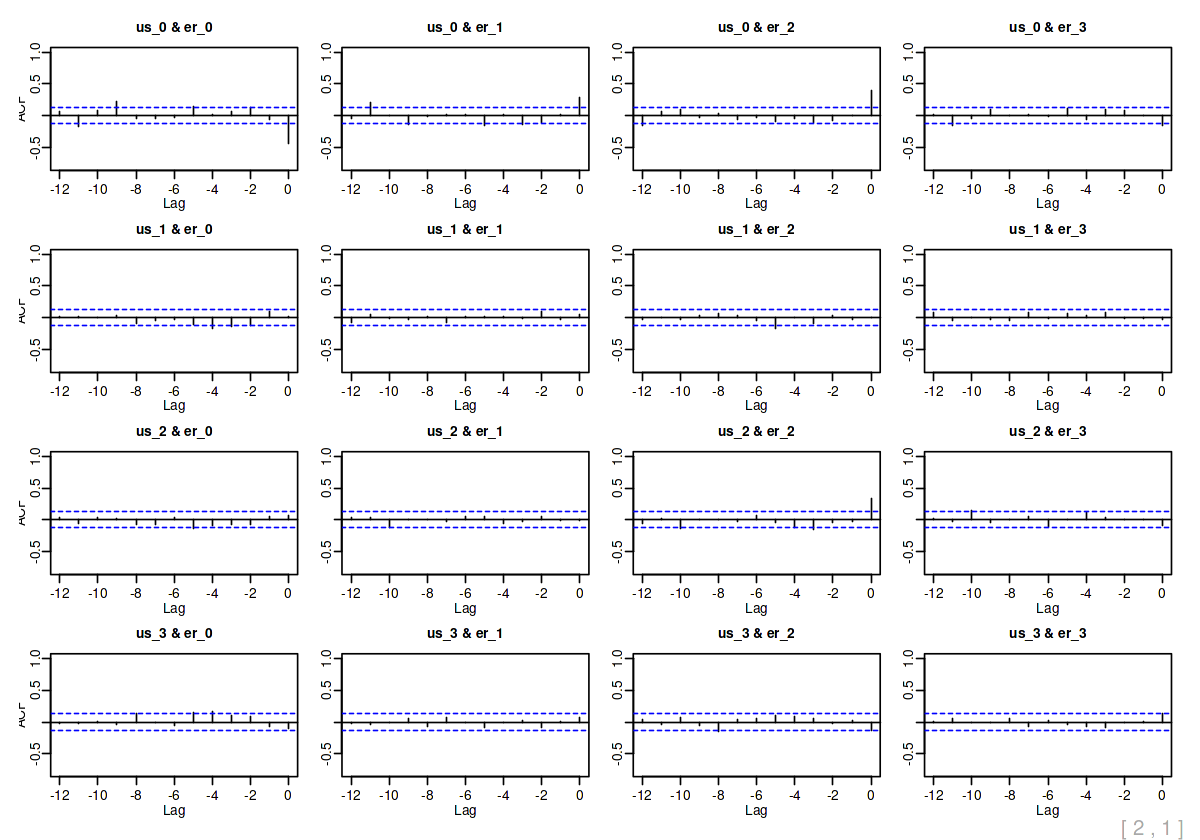

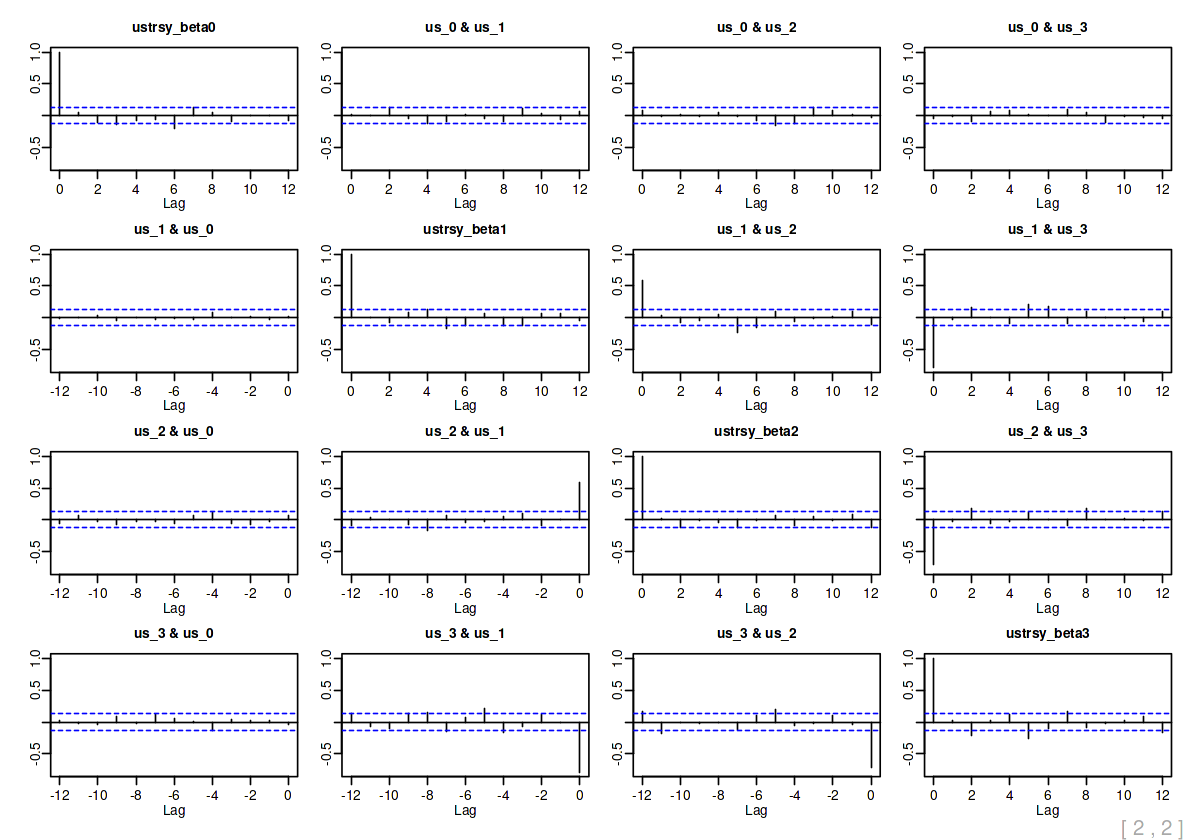

In [7]:
plot_residuals(residuals(varmodel))
plot_fitted_vs_residuals(fitted(varmodel), residuals(varmodel))
acf(residuals(varmodel), lag.max = 12)

## Simulate $VAR(p=1)$ model with skewed Student's t distributed noise

In [8]:
# Define functions

msv_beta2zero <- function(betas, durs, taus){
    betas %*% t(msv_mat_mod(durs = durs, taus = taus))
}

msv_beta2px <- function(betas, durs, taus){
    x = msv_beta2zero(betas, durs, taus) |> as.data.frame()
    mapply(\(x, y)exp(-y * x / 100), x = x, y = durs |> unlist(use.names = FALSE)) |>
    set_rownames(rownames(x))
}

zero2px <- function(zeros, durs){
    mapply(
        \(x, y)exp(-y * x / 100),
        x = zeros |> as.data.frame(), y = durs |> unlist(use.names = FALSE),
        SIMPLIFY = TRUE
    ) |> set_rownames(rownames(zeros))
}

tot_rets <- function(px_open_list, px_close_list)mapply(
    \(x, y)(y / x - 1) |> set_colnames(colnames(x)),
    x = px_open_list, y = px_close_list,
    SIMPLIFY = FALSE
)

tot_rets_cumul <- function(tot_rets)lapply(tot_rets,
                                           \(x)apply(x, 2, \(r)cumprod(1 + r) - 1)
                                           )

tidy_simulations <- function(simlist){
    simlist |> lapply(function(df) {
        as.data.table(df, keep.rownames = "period") |>
        melt(id.vars = "period", value.name = "y", variable.name = "tenor")}) |> 
    rbindlist(idcol = "sim_id") |> as_tibble() |>
    mutate(curve = stringr::str_extract(tenor, "^(.+?)_", group = 1) |> toupper(),
           dur = stringr::str_extract(tenor, "_(.+?)$", group = 1) |> as.numeric())
}

In [9]:
# Init results object and define constants

simresults <- list(var = new.env(), dcc = new.env(), ahead = new.env(), lgbm = new.env(), nnetsauce = new.env())
relevantdurs <- c(0.5, 1, 1.5, 2, 5, 10, 15)
durs = list(eurgovy = relevantdurs, ustrsy = relevantdurs)
taus = list(eurgovy = opt_joint_taus_mod[1:2], ustrsy = opt_joint_taus_mod[3:4])

### Joint $\beta$ simulation

In [10]:
tictoc::tic()

NSIM <- 1000L
RNDSEED <- 776655L
STEPS <- 36L

set.seed(RNDSEED)

rinnov <- ghyp::fit.tmv(varmodel$residuals |> scale(center = FALSE, scale = FALSE), silent = TRUE)

cl <- ifelse(NSIM < 5001, 1, 4)

simresults$var$betasims <- pbapply::pblapply(1:NSIM, FUN = function(i) {
  betasim <- tsDyn::VAR.sim(varmodel$coefficients, n = STEPS, lag = 1, include = "none", starting = mybetas_joint |> diff() |> tail(1), innov = ghyp::rghyp(n = STEPS, rinnov), show.parMat = FALSE, returnStarting = FALSE) %>%
    rbind(mybetas_joint |> tail(1), .) |>
    apply(2, cumsum)
  rownames(betasim) <- paste0("T+", 0:STEPS)
  return(betasim)
}, cl = cl)

tictoc::toc()

3.908 sec elapsed


### Calculate zero yields and total return paths from simulated $\beta$s

In [11]:
tictoc::tic()
with(simresults$var, {
    ycsims_open <- betasims |> lapply(\(.x)head(.x, -1) |> msv_beta2zero(durs = durs, taus = taus))
    ycsims_close <- betasims |> lapply(\(.x, durs_)tail(.x, -1) |> msv_beta2zero(durs = durs_, taus = taus), durs_ = lapply(durs, \(d)d - 1 / 12))

    px_open <- ycsims_open |> lapply(zero2px, durs = durs)
    px_close <- ycsims_close |> lapply(zero2px, durs = lapply(durs, \(d)d - 1 / 12))

    total_rets <- tot_rets(px_open, px_close)
    total_rets_cumul <- tot_rets_cumul(total_rets)

    ycsims_close_tidy <- tidy_simulations(ycsims_close)
    total_rets_cumul_tidy <- tidy_simulations(total_rets_cumul)
})
tictoc::toc()

8.777 sec elapsed


### Visualize zero yield and total return distribution by duration at horizon date

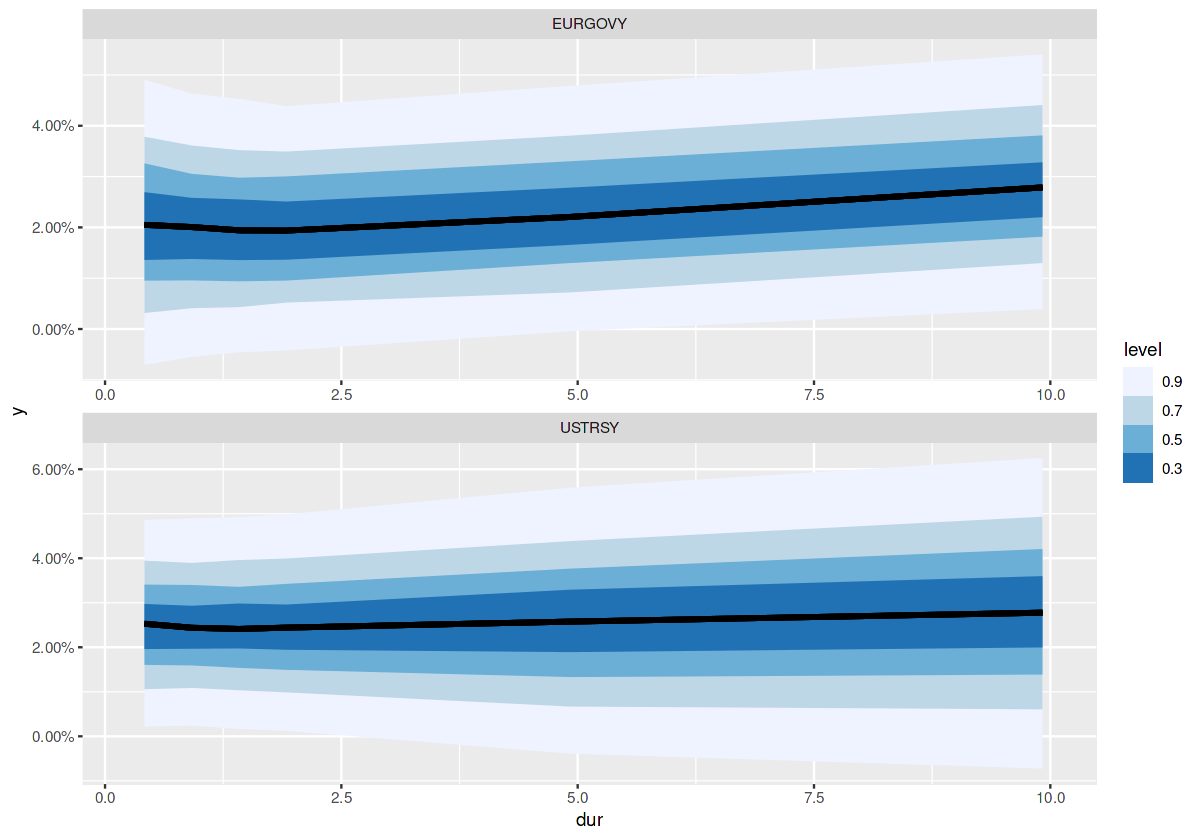

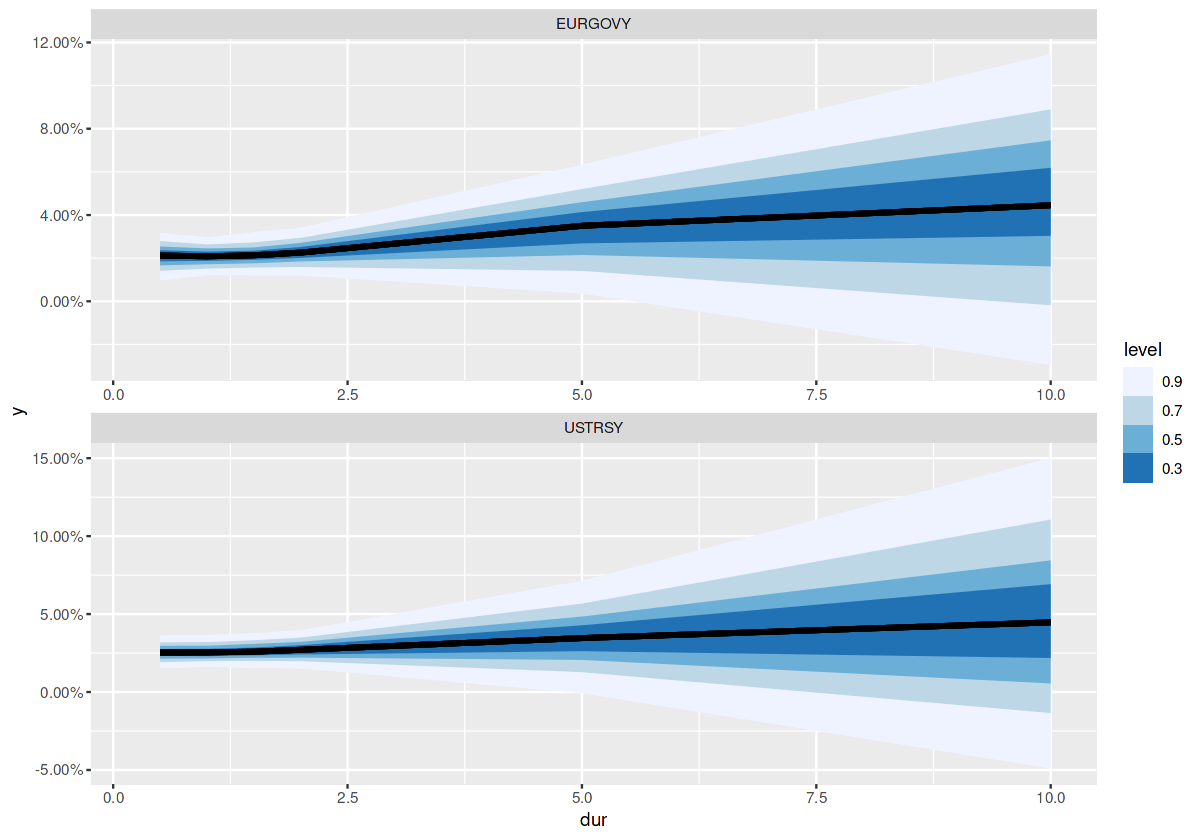

In [12]:
quantiles <- c(0.3, 0.5, 0.7, 0.9)

plot_lineribbon <- function(data, quantiles, xlim = c(0.25, 15)){
    {
        ggplot(data, aes(x = dur, y = y)) +
        stat_lineribbon(.width = quantiles) +
        scale_fill_brewer() + 
        scale_y_continuous(labels = scales::percent_format(accuracy = 0.01)) +
        facet_wrap(~curve, ncol = 1, scales = "free")  + xlim(xlim)
    } |> print() |> suppressWarnings()
}

simresults$var$ycsims_close_tidy |> filter(period == "T+36") |> 
    mutate(y = y / 100) |> plot_lineribbon(quantiles, xlim = c(0.25, 10))
simresults$var$total_rets_cumul_tidy |> filter(period == "T+36") |> 
    mutate(y = (1 + y)^(1 / 3) - 1) |> plot_lineribbon(quantiles, xlim = c(0.25, 10))

## Fit $VAR(p)-DCC-GARCH(p, q)$ model to differenced $\beta$ data
### Perform grid search to find *„the best”* model
Applying brute force aka grid search to tuning hyperparameters. As it runs long some part of R code is deactivated and results are saved for reference.

In [13]:
# Set a "plan" for how the code should run
future::plan(future::multicore, workers = 4)

# Workaround to show progress bar
options(progressr.enable = TRUE)
progressr::handlers(progressr::handler_txtprogressbar(file = stdout()))
options(progressr.delay_stdout = FALSE)

# Define the range of orders to search
p_values <- 1:3
q_values <- 0:2
garch_p_values <- 1:2
garch_q_values <- 1:2
dcc_p_values <- 1:2
dcc_q_values <- 1:2
variance_model_values <- c("sGARCH", "gjrGARCH", "iGARCH")

# Create a data frame of all parameter combinations
param_grid <- expand.grid(p = p_values, q = q_values, 
                          garch_p = garch_p_values, garch_q = garch_q_values, 
                          dcc_p = dcc_p_values, dcc_q = dcc_q_values, 
                          variance_model = variance_model_values,
                          stringsAsFactors = FALSE
                         )

# Function to fit the model and calculate AIC
fit_model <- function(p, q, garch_p, garch_q, dcc_p, dcc_q, variance_model, ...) {
    uspec <- ugarchspec(variance.model = list(model = variance_model, garchOrder = c(garch_p, garch_q)),
                      mean.model = list(armaOrder = c(p, q), include.mean = FALSE),
                      distribution.model = "norm")
    spec <- dccspec(uspec = multispec(replicate(ncol(mybetas_joint_diff), uspec)), 
                  dccOrder = c(dcc_p, dcc_q), distribution = "mvnorm")
    fit <- dccfit(spec, data = mybetas_joint_diff, ...)
    return(fit)
}

fit_model_safe <- purrr::possibly(fit_model, otherwise = NA)

In [14]:
# Freezed list of the 10 models with lowest BISs

best_models <- structure(list(rn = c(289L, 325L, 361L, 397L, 1L, 37L, 73L, 109L, 
290L, 307L), Akaike = c(7.4232654298263983, 7.4251925141243689, 
7.4314621497965199, 7.4333892435514022, 7.427861640174509, 7.4278100321774074, 
7.4360583948043129, 7.4360067650620412, 7.5110405001175362, 7.5137365481707077
), Bayes = c(8.4408840527600759, 8.4571437937190836, 8.4634134293912346, 
8.4796731798071558, 8.560141516396488, 8.5744225650604253, 8.5826709276873299, 
8.5969519546060962, 8.6433203763395152, 8.6460164243926876), 
    Shibata = c(7.2999673608832731, 7.2988656940282111, 7.3051353297003621, 
    7.3040071016441876, 7.2796045198937707, 7.2763189799273231, 
    7.2845673425542286, 7.2812572731410636, 7.3627833798367979, 
    7.3654794278899693), `Hannan-Quinn` = c(7.8331059994813685, 
    7.8408054861688461, 7.8470751218409971, 7.8547746179853863, 
    7.883881428945533, 7.8896022233379384, 7.8978505859648429, 
    7.9035713586120782, 7.9670602888885602, 7.9697563369417317
    ), p = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 1L), q = c(0L, 
    0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L), garch_p = c(1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L), garch_q = c(1L, 1L, 1L, 
    1L, 1L, 1L, 1L, 1L, 1L, 2L), dcc_p = c(1L, 2L, 1L, 2L, 1L, 
    2L, 1L, 2L, 1L, 1L), dcc_q = c(1L, 1L, 2L, 2L, 1L, 1L, 2L, 
    2L, 1L, 1L), variance_model = c("iGARCH", "iGARCH", "iGARCH", 
    "iGARCH", "sGARCH", "sGARCH", "sGARCH", "sGARCH", "iGARCH", 
    "iGARCH")), row.names = c(NA, 10L), class = "data.frame")

best_models

,rn,Akaike,Bayes,Shibata,Hannan-Quinn,p,q,garch_p,garch_q,dcc_p,dcc_q,variance_model
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,289,7.423265,8.440884,7.299967,7.833106,1,0,1,1,1,1,iGARCH
2,325,7.425193,8.457144,7.298866,7.840805,1,0,1,1,2,1,iGARCH
3,361,7.431462,8.463413,7.305135,7.847075,1,0,1,1,1,2,iGARCH
4,397,7.433389,8.479673,7.304007,7.854775,1,0,1,1,2,2,iGARCH
5,1,7.427862,8.560142,7.279605,7.883881,1,0,1,1,1,1,sGARCH
6,37,7.427810,8.574423,7.276319,7.889602,1,0,1,1,2,1,sGARCH
7,73,7.436058,8.582671,7.284567,7.897851,1,0,1,1,1,2,sGARCH
8,109,7.436007,8.596952,7.281257,7.903571,1,0,1,1,2,2,sGARCH
9,290,7.511041,8.643320,7.362783,7.967060,2,0,1,1,1,1,iGARCH


Among the model types the simplest model is the best. The iGARCH variace model produced the lowest BICs.

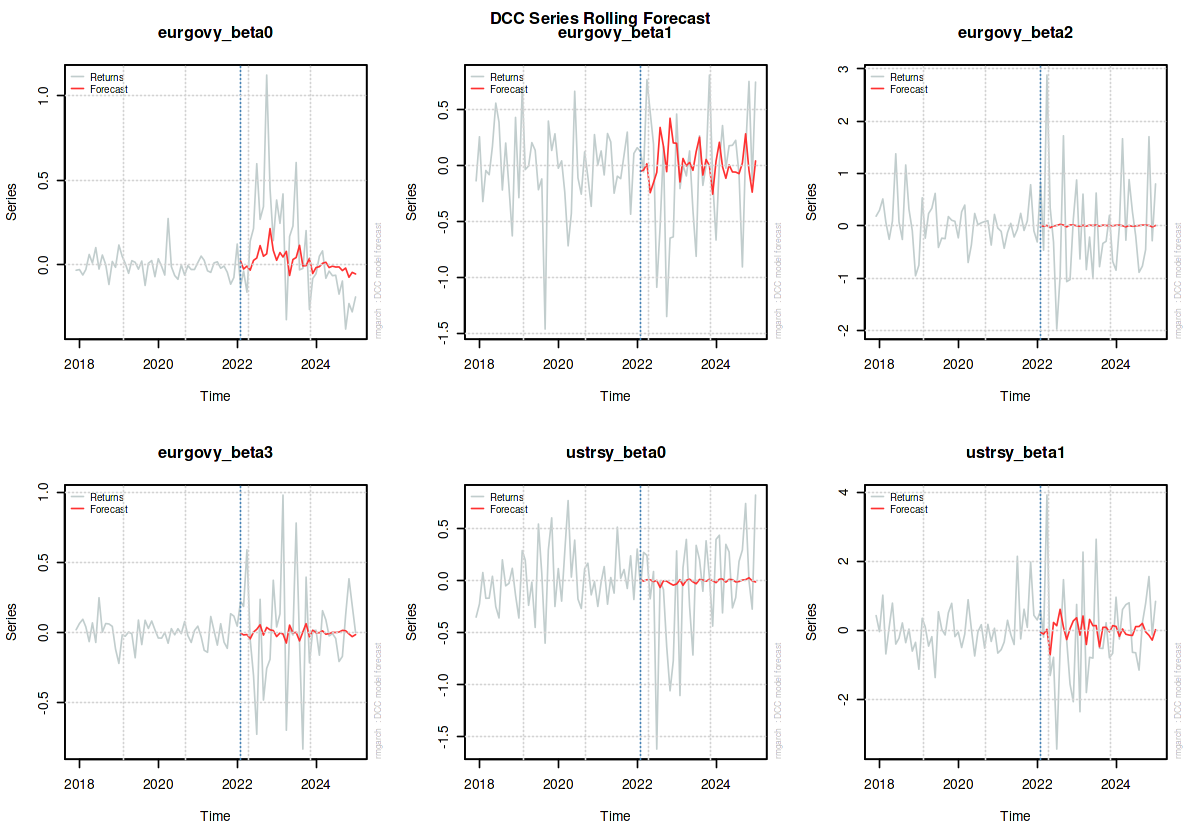

In [15]:
options(warn = -1)

with(best_models[1, ],{
    dccmodel_oos <- fit_model(p, q, garch_p, garch_q, dcc_p, dcc_q, variance_model,
                          out.sample = STEPS)
    dccforecast(dccmodel_oos, n.ahead = 1, n.roll = STEPS) |> plot(series = c(1, 2, 3, 5, 6, 7), which=1)
    }
    )

options(warn = 0)

## Refit, diagnostics and simulation

In [16]:
options(warn = -1)

with(best_models[1, ],{
    dccmodel <<- fit_model(p, q, garch_p, garch_q, dcc_p, dcc_q, variance_model,
                          out.sample = 0L)
    })

options(warn = 0)

### Diagnostic plots

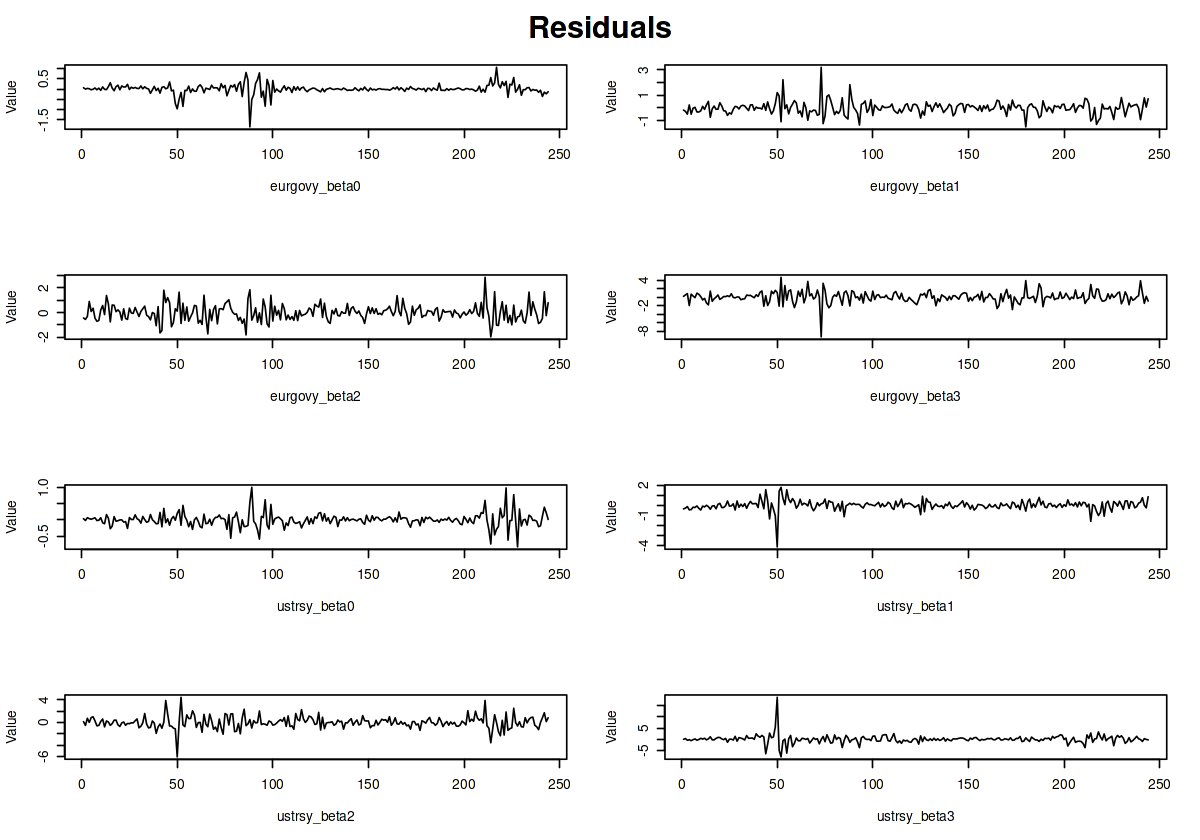

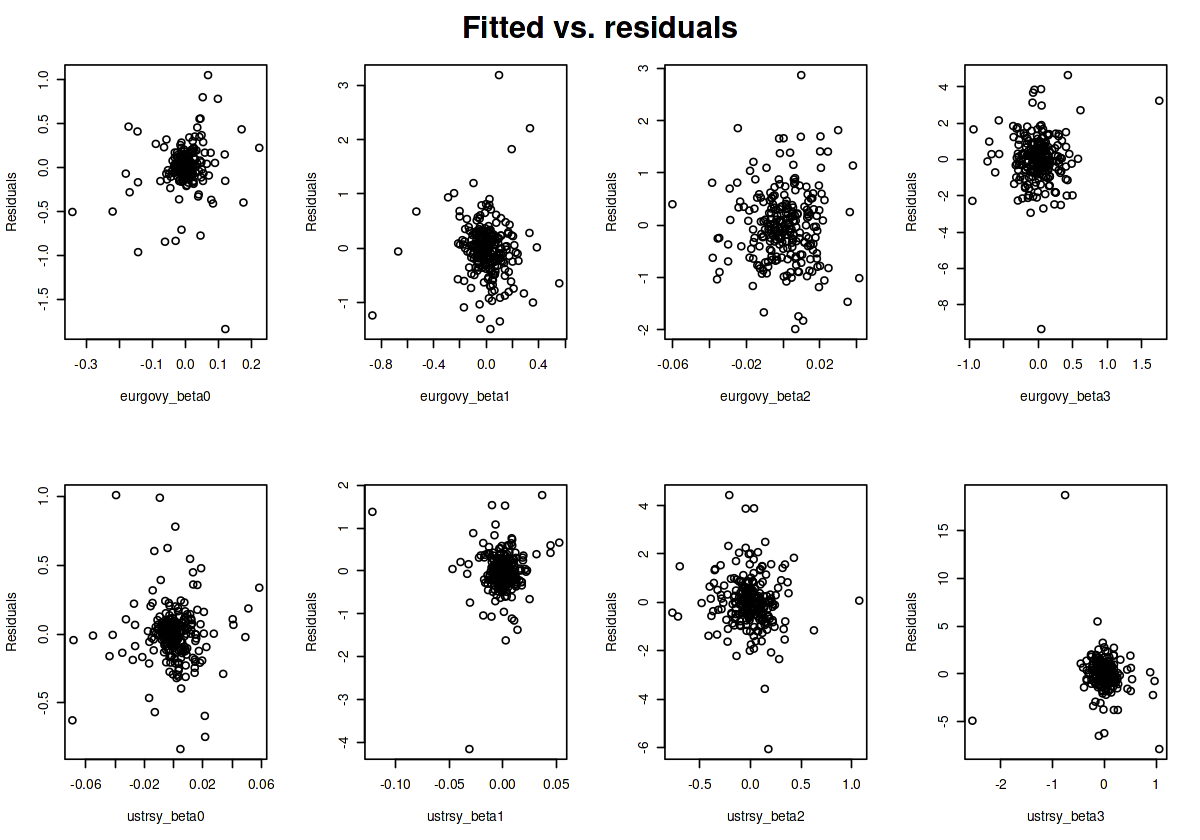

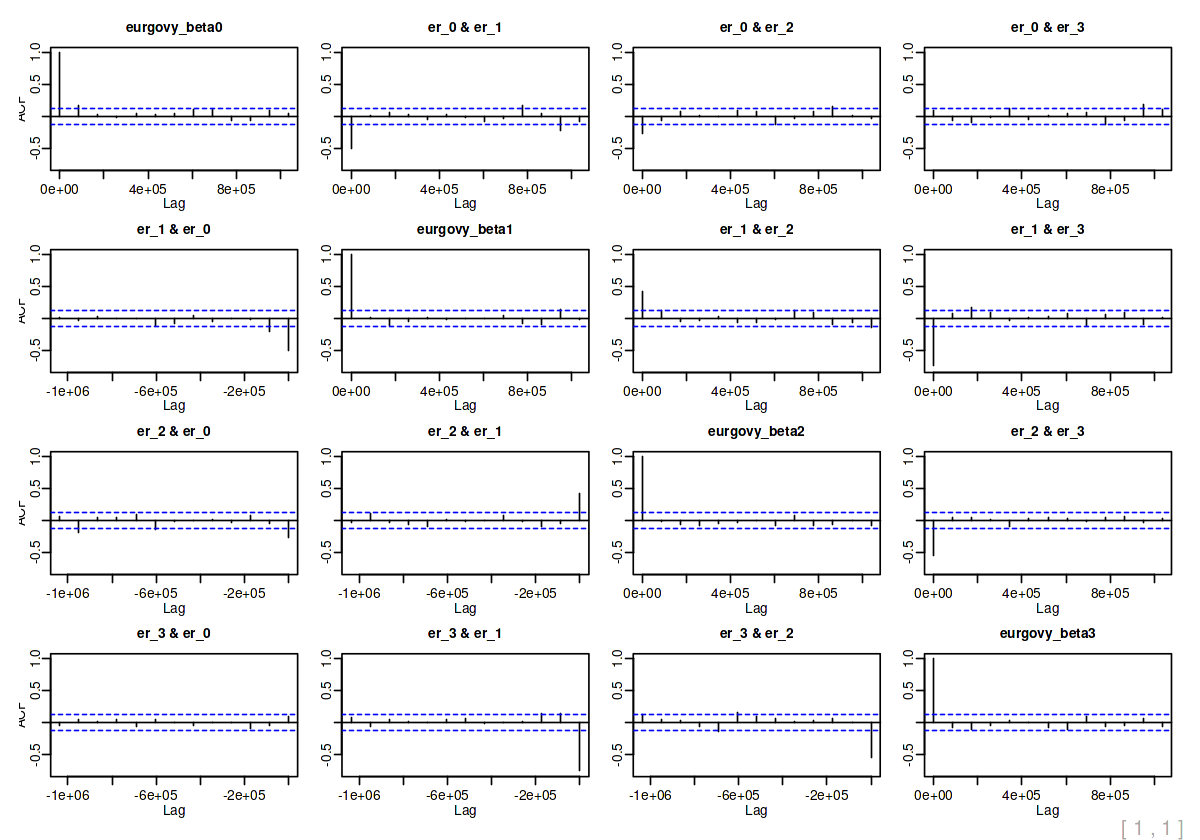

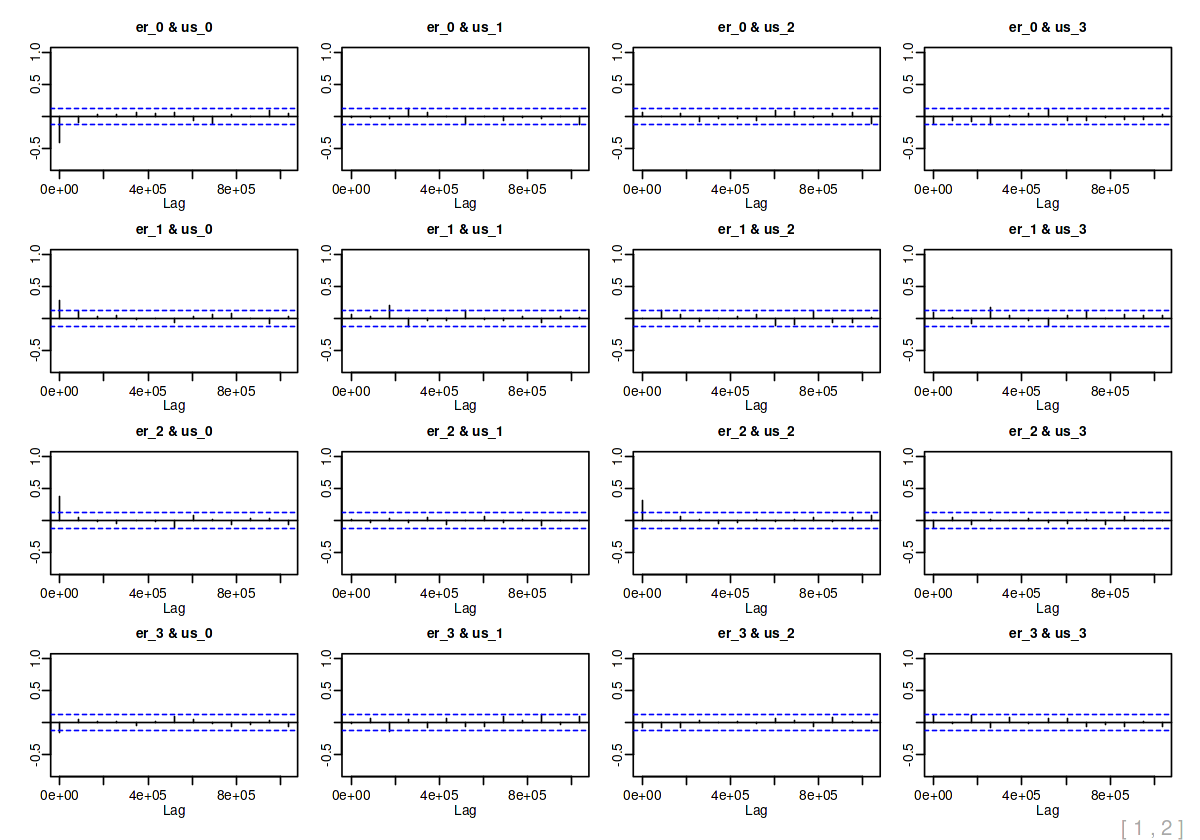

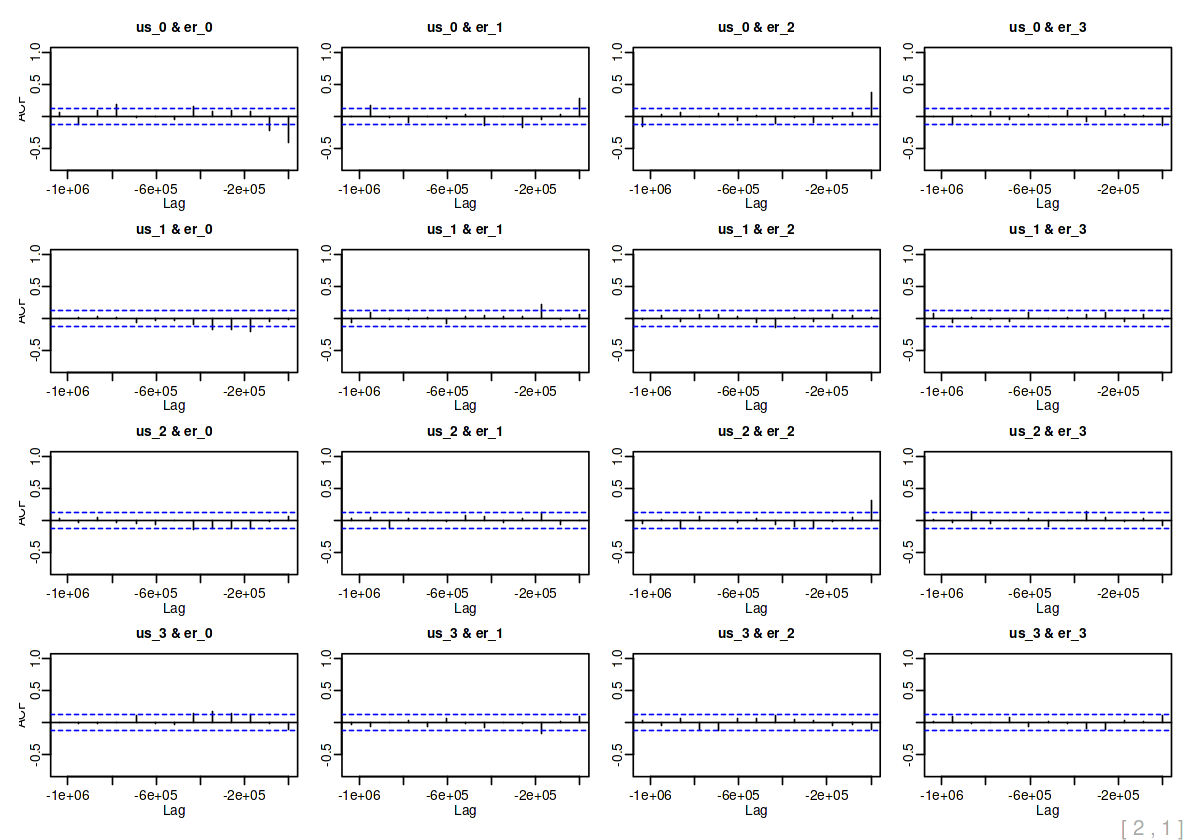

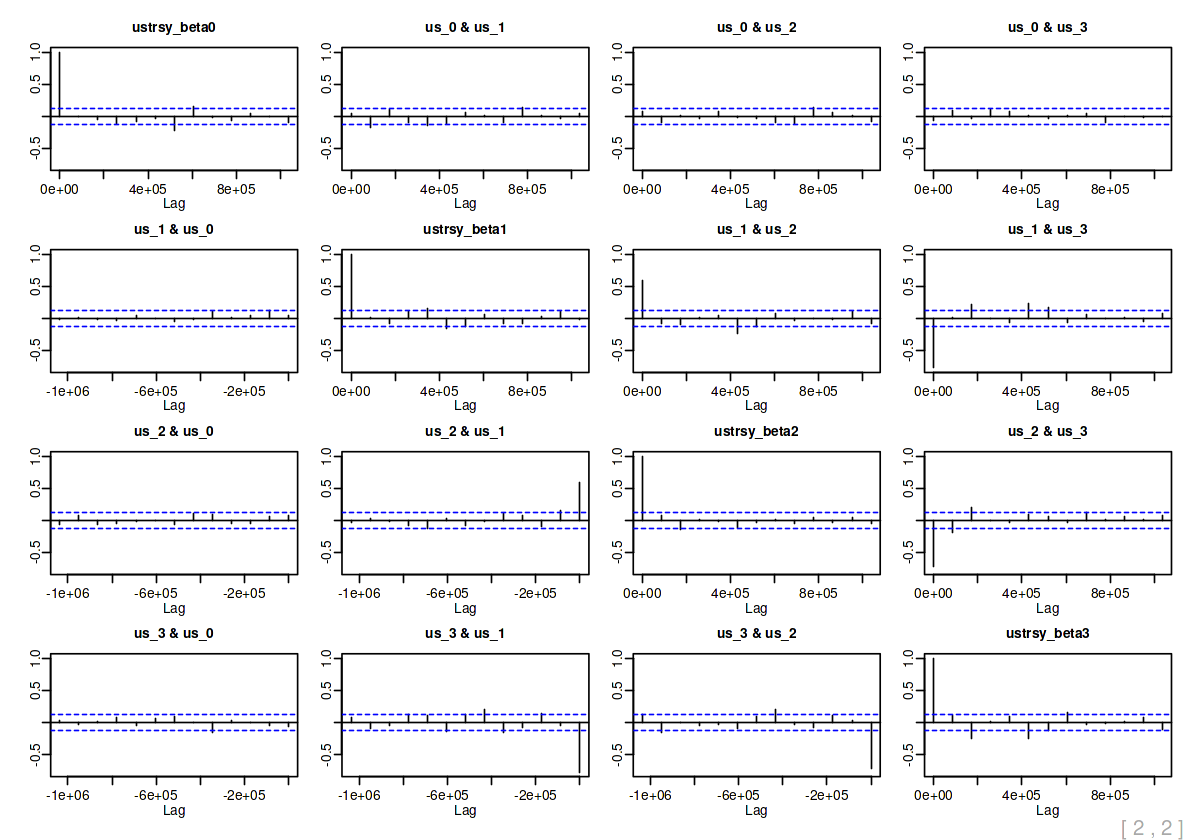

In [17]:
plot_residuals(residuals(dccmodel))
plot_fitted_vs_residuals(fitted(dccmodel), residuals(dccmodel))
acf(residuals(dccmodel), lag.max = 12)

According to visual inspection we see that the in-sample residuals are mainly uncorrelated with the one step ahead fits. The acf function show little lagged (cross-)correlation features of residuals. This is the good news.

The bad one is that the residuals seem not to be homoscedastic: maybe there are more than only one regime in the data generating process of *beta*s.

For now we skip more formal tests (homoscedasticity, whiteness and normality of residuals).

### Joint $\beta$ simulation

In [18]:
options(warn = -1)

simresults$dcc$betasims <- lapply(1:NSIM,
                       \(i, mod)fitted(mod, i)  %>%
                           rbind(mybetas_joint |> tail(1), .) |> 
                           apply(2, cumsum) |>
                           set_rownames(paste0("T+", 0:STEPS))
                       , mod = dccsim(dccmodel, n.sim = STEPS, m.sim = NSIM, 
                                      n.start = 0, startMethod = "sample", 
                                      rseed = RNDSEED)
                       )

options(warn = 0)

In [19]:
save.image("results.RData")

### Calculate zero yields and total return paths from simulated $\beta$s

In [20]:
tictoc::tic()
with(simresults$dcc, {
    ycsims_open <- betasims |> lapply(\(.x)head(.x, -1) |> msv_beta2zero(durs = durs, taus = taus))
    ycsims_close <- betasims |> lapply(\(.x, durs_)tail(.x, -1) |> msv_beta2zero(durs = durs_, taus = taus), durs_ = lapply(durs, \(d)d - 1 / 12))

    px_open <- ycsims_open |> lapply(zero2px, durs = durs)
    px_close <- ycsims_close |> lapply(zero2px, durs = lapply(durs, \(d)d - 1 / 12))

    total_rets <- tot_rets(px_open, px_close)
    total_rets_cumul <- tot_rets_cumul(total_rets)
    
    ycsims_close_tidy <- tidy_simulations(ycsims_close)
    total_rets_cumul_tidy <- tidy_simulations(total_rets_cumul)
})
tictoc::toc()

8.12 sec elapsed


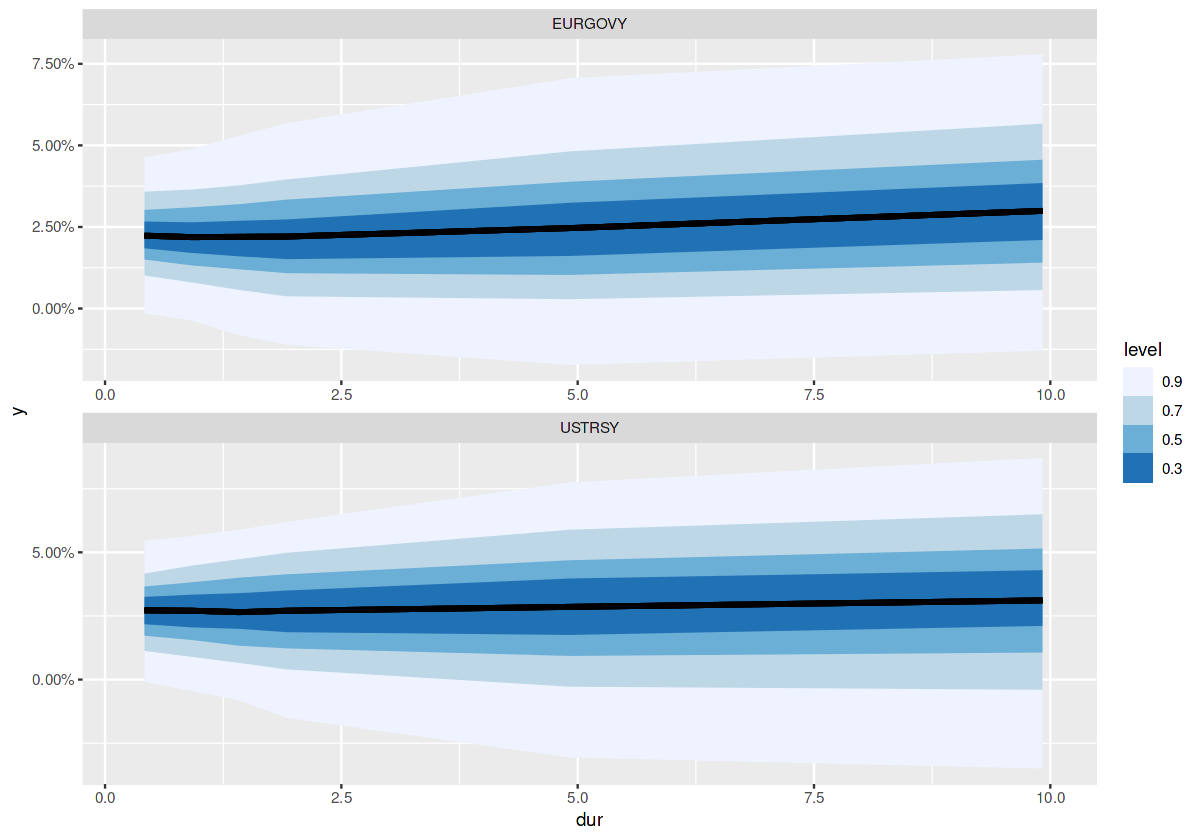

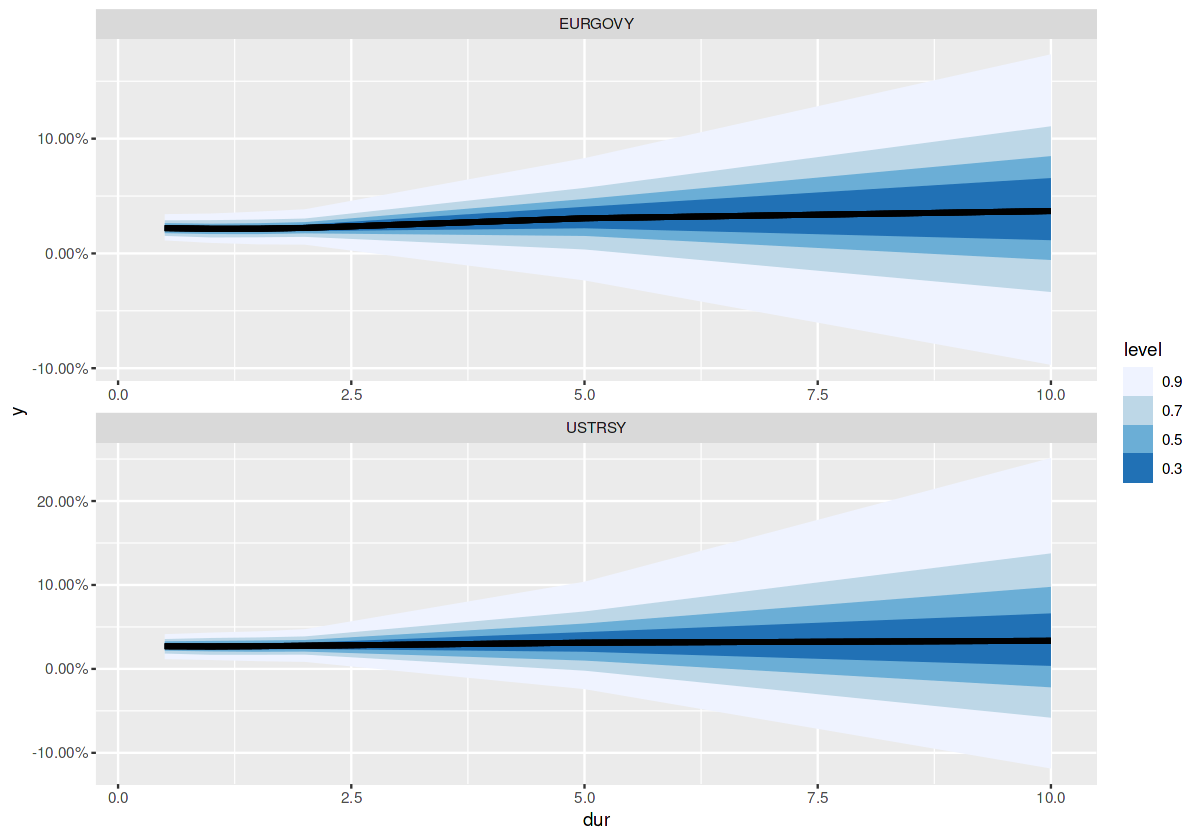

In [21]:
simresults$dcc$ycsims_close_tidy |> filter(period == "T+36") |> 
    mutate(y = y / 100) |> plot_lineribbon(quantiles, xlim = c(0.25, 10))
simresults$dcc$total_rets_cumul_tidy |> filter(period == "T+36") |> 
    mutate(y = (1 + y)^(1 / 3) - 1) |> plot_lineribbon(quantiles, xlim = c(0.25, 10))

# ML time series modelling of $\beta$s

In [22]:
paramgrid <- tidyr::expand_grid(lags = c(1, 2), dropout = c(
  0, 0.05, 0.1, 0.2
), type_forecast = c("recursive", "direct"))
rmse <- paramgrid[[1]] * 0
pb <- utils::txtProgressBar(min = 0, max = nrow(paramgrid), style = 3)

for (rw in seq_len(nrow(paramgrid))) {
  par <- paramgrid[rw, ] |> as.list()
  rmse[rw] <- sapply(
    seq.int(120, nrow(mybetas_joint_diff) - 36, 6), function(idx) {
      mean((ahead::ridge2f(mybetas_joint_diff[1:idx, ], h = 36, B = 0L, lags = par$lags, dropout = par$dropout, type_forecast = par$type_forecast)$mean - mybetas_joint_diff[(idx + 1):(idx + 36), ])^2)
    }
  ) |> mean()
  utils::setTxtProgressBar(pb, rw)
}
close(pb)

  |======================================================================| 100%


In [23]:
paramgrid |>
  mutate(rn = row_number(), .before = 1, rmse = rmse) |>
  arrange(rmse) |> head()

rn,rmse,lags,dropout,type_forecast
<int>,<dbl>,<dbl>,<dbl>,<chr>
13,0.4927016,2,0.10,recursive
9,0.4930706,2,0.00,recursive
15,0.4939195,2,0.20,recursive
11,0.4942621,2,0.05,recursive
10,0.4955098,2,0.00,direct
12,0.4958680,2,0.05,direct


### Model fit and joint $\beta$ simulation

In [24]:

temp = ahead::ridge2f(mybetas_joint_diff |> head(-36), h = STEPS, type_pi = "movingblockbootstrap", block_size = 12,  B = 100L, lags = 2, dropout = 0.1, type_forecast = "recursive", seed = RNDSEED)$sims

  |======================================================================| 100%


In [25]:
aheadmodel <- ahead::ridge2f(mybetas_joint_diff, h = STEPS, type_pi = "movingblockbootstrap", B = NSIM, lags = 2, dropout = 0.1, type_forecast = "recursive", seed = RNDSEED)
simresults$ahead$betasims <- aheadmodel$sims |> lapply(\(m)m |> zoo::coredata() |> as.matrix() |> set_rownames(paste0("T+", 1:STEPS))) |> 
    lapply(\(.x)rbind(mybetas_joint |> tail(1), .x)) |> 
    lapply(\(.x)apply(.x, 2, cumsum))

  |======================================================================| 100%


### Diagnostic plots

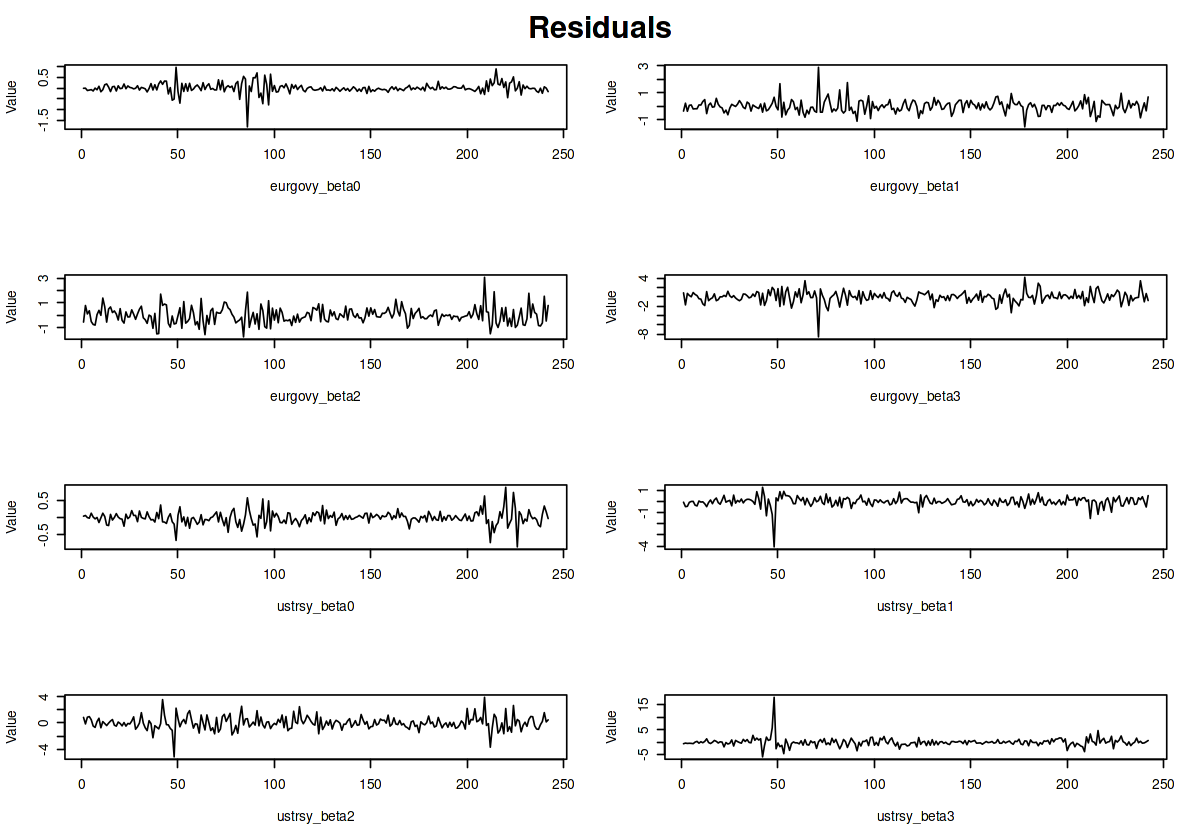

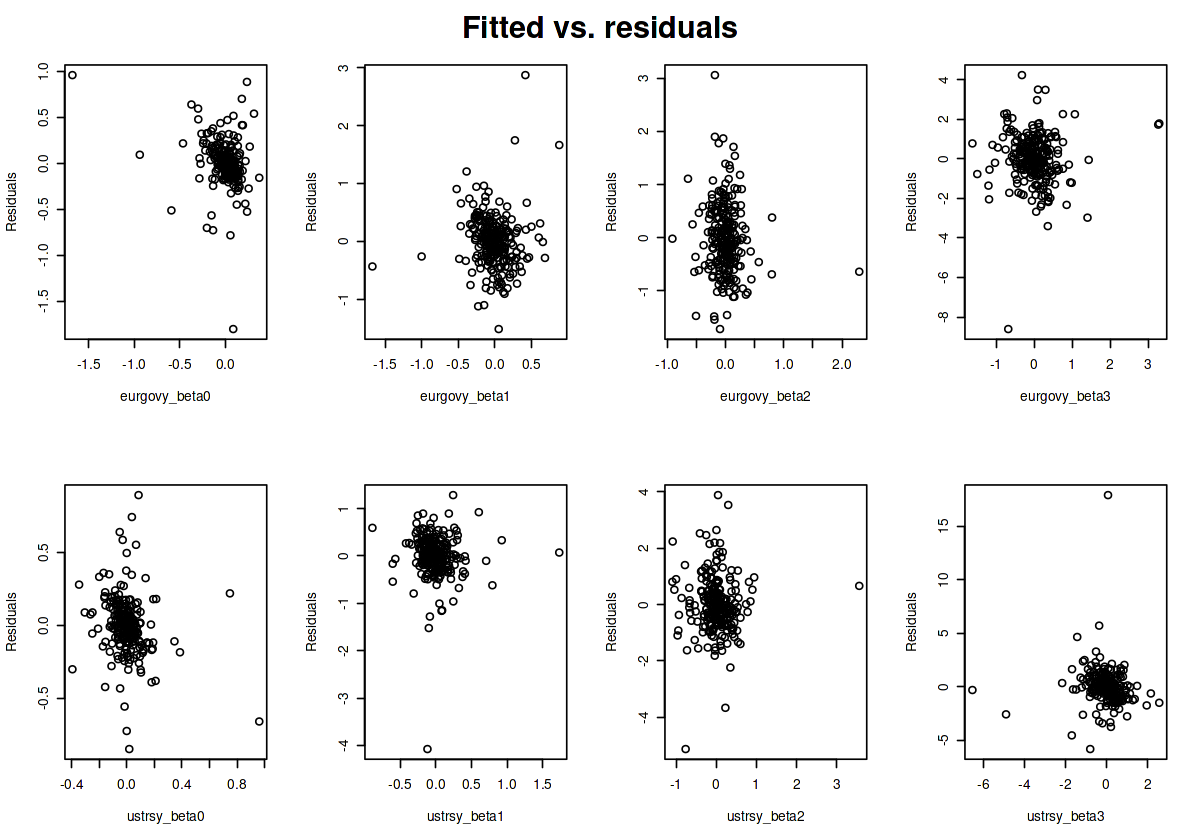

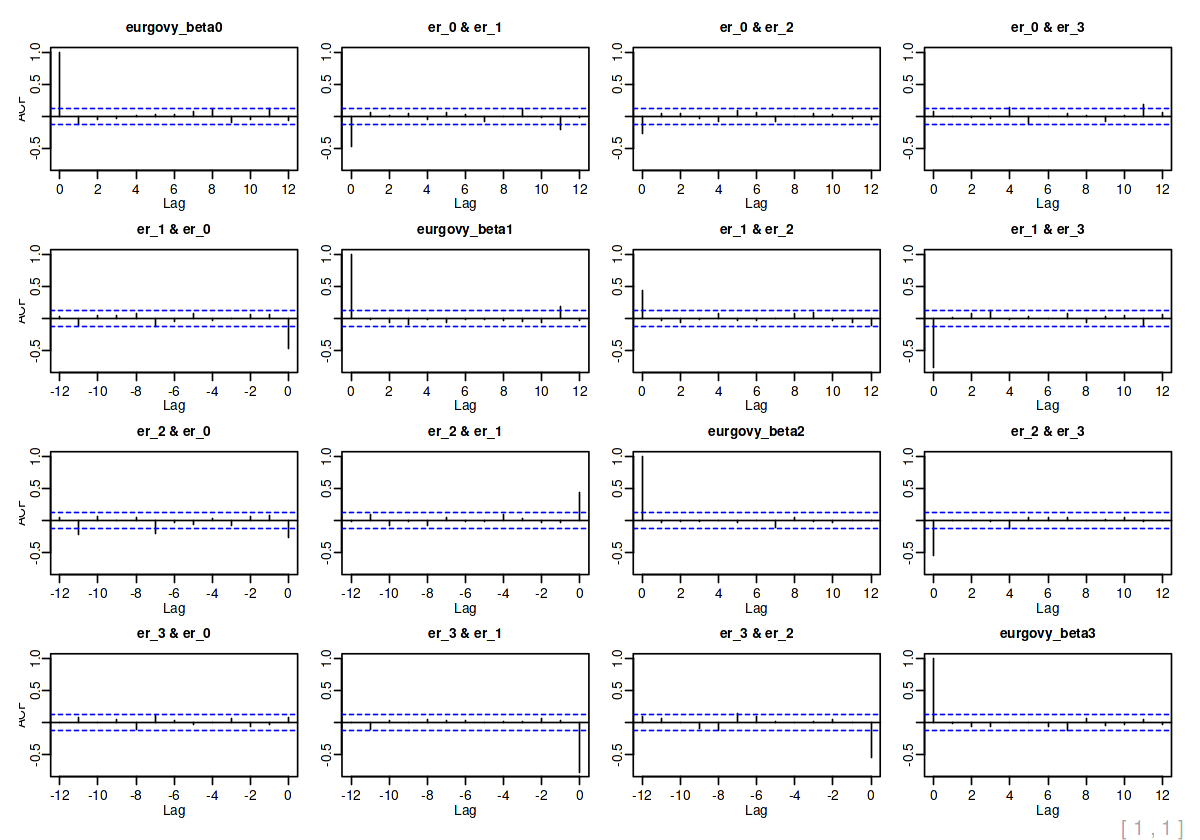

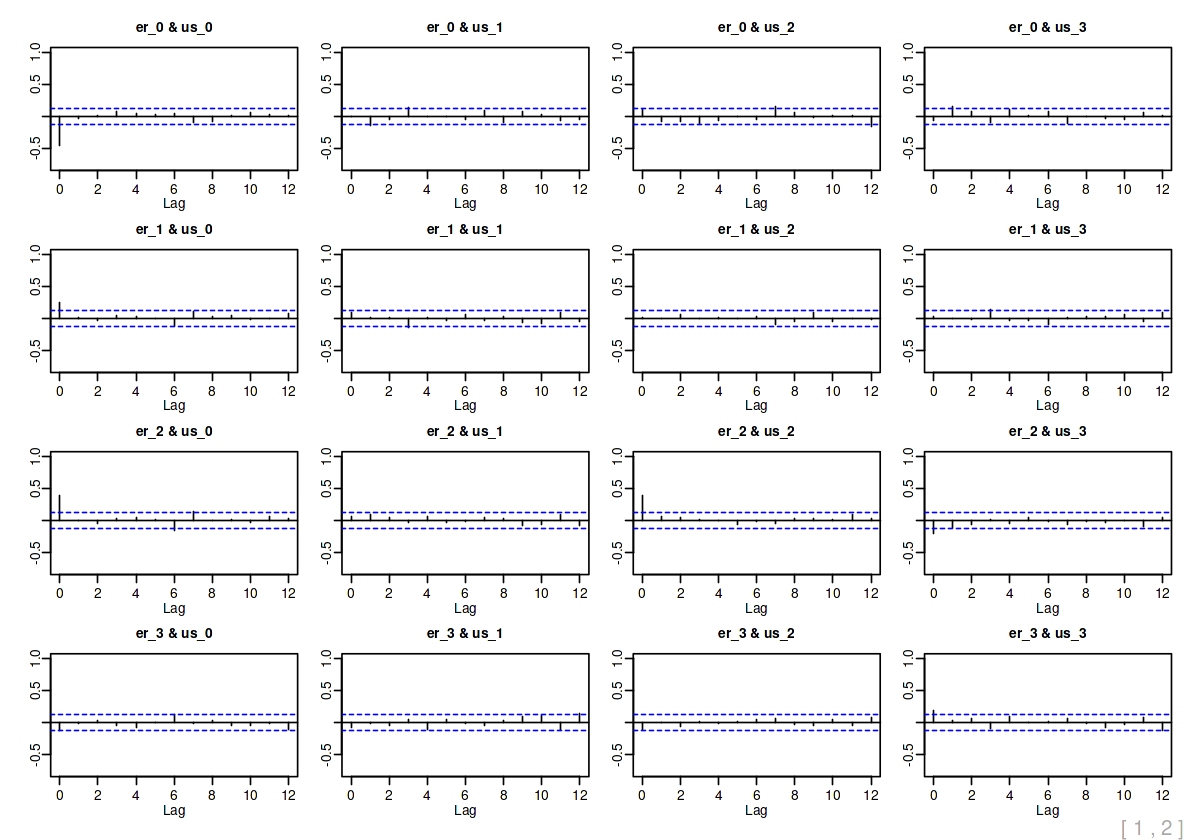

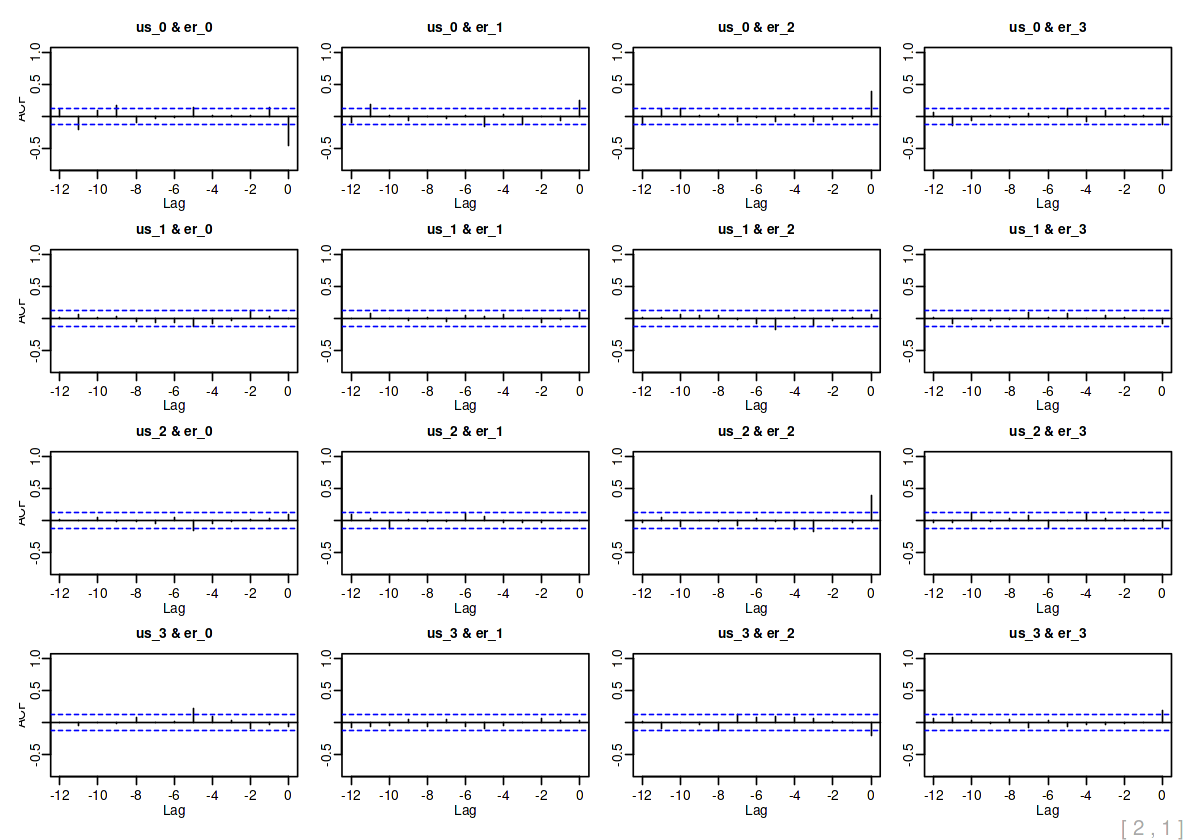

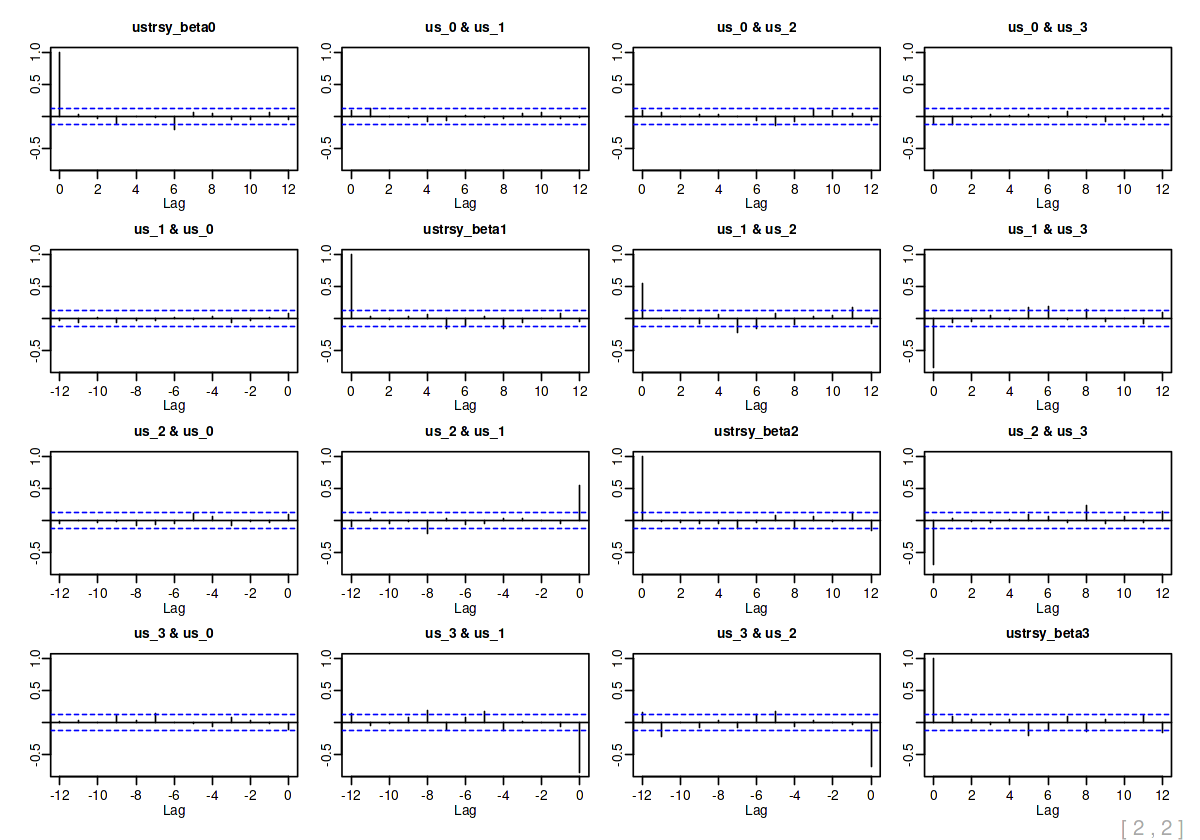

In [26]:
plot_residuals(residuals(aheadmodel))
plot_fitted_vs_residuals((mybetas_joint_diff|>tail(-2)) - residuals(aheadmodel), residuals(aheadmodel))
acf(residuals(aheadmodel), lag.max = 12)

### Calculate zero yields and total return paths from simulated $\beta$s

In [27]:
tictoc::tic()
with(simresults$ahead, {
    ycsims_open <- betasims |> lapply(\(.x)head(.x, -1) |> msv_beta2zero(durs = durs, taus = taus))
    ycsims_close <- betasims |> lapply(\(.x, durs_)tail(.x, -1) |> msv_beta2zero(durs = durs_, taus = taus), durs_ = lapply(durs, \(d)d - 1 / 12))

    px_open <- ycsims_open |> lapply(zero2px, durs = durs)
    px_close <- ycsims_close |> lapply(zero2px, durs = lapply(durs, \(d)d - 1 / 12))

    total_rets <- tot_rets(px_open, px_close)
    total_rets_cumul <- tot_rets_cumul(total_rets)
    
    ycsims_close_tidy <- tidy_simulations(ycsims_close)
    total_rets_cumul_tidy <- tidy_simulations(total_rets_cumul)
})
tictoc::toc()

8.187 sec elapsed


In [28]:
simresults$ahead$total_rets_cumul_tidy |> filter(period == "T+36") |>
    mutate(y = (1 + y)^(1 / 3) - 1) |> group_by(tenor) |> summarize(median(y), mean(y), sd(y)) |> t() |>
    janitor::row_to_names(row_number = 1) |> as_tibble(rownames = "metric") |> 
    mutate(across(matches("eur|ust"), ~(as.numeric(.x)-as.numeric(eurgovy_0.500))*10000))

metric,eurgovy_0.500,eurgovy_1.000,eurgovy_1.500,eurgovy_2.000,eurgovy_5.000,eurgovy_10.000,eurgovy_15.000,ustrsy_0.500,ustrsy_1.000,ustrsy_1.500,ustrsy_2.000,ustrsy_5.000,ustrsy_10.000,ustrsy_15.000
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
median(y),0,-6.59510,1.08060,16.85320,145.6770,294.0109,340.1367,50.47180,54.24250,63.25500,73.14060,144.7461,255.0079,333.3491
mean(y),0,-2.89650,4.50710,18.74010,143.6148,268.7485,311.4674,46.68710,52.63000,61.46260,72.33680,154.3975,283.7227,390.6018
sd(y),0,-28.15974,-30.98557,-16.52059,109.1107,316.3485,536.2141,-8.82201,-23.49274,-22.27345,-11.27741,145.0414,500.2243,891.3973


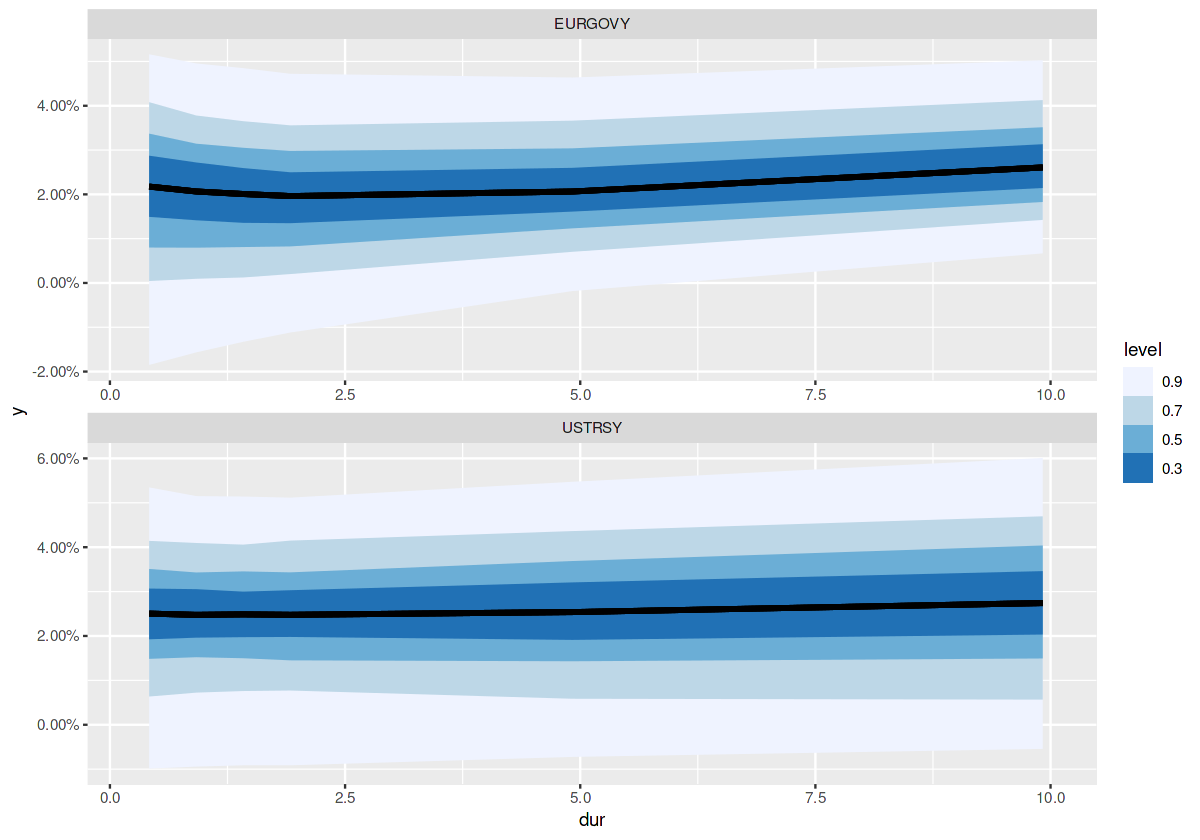

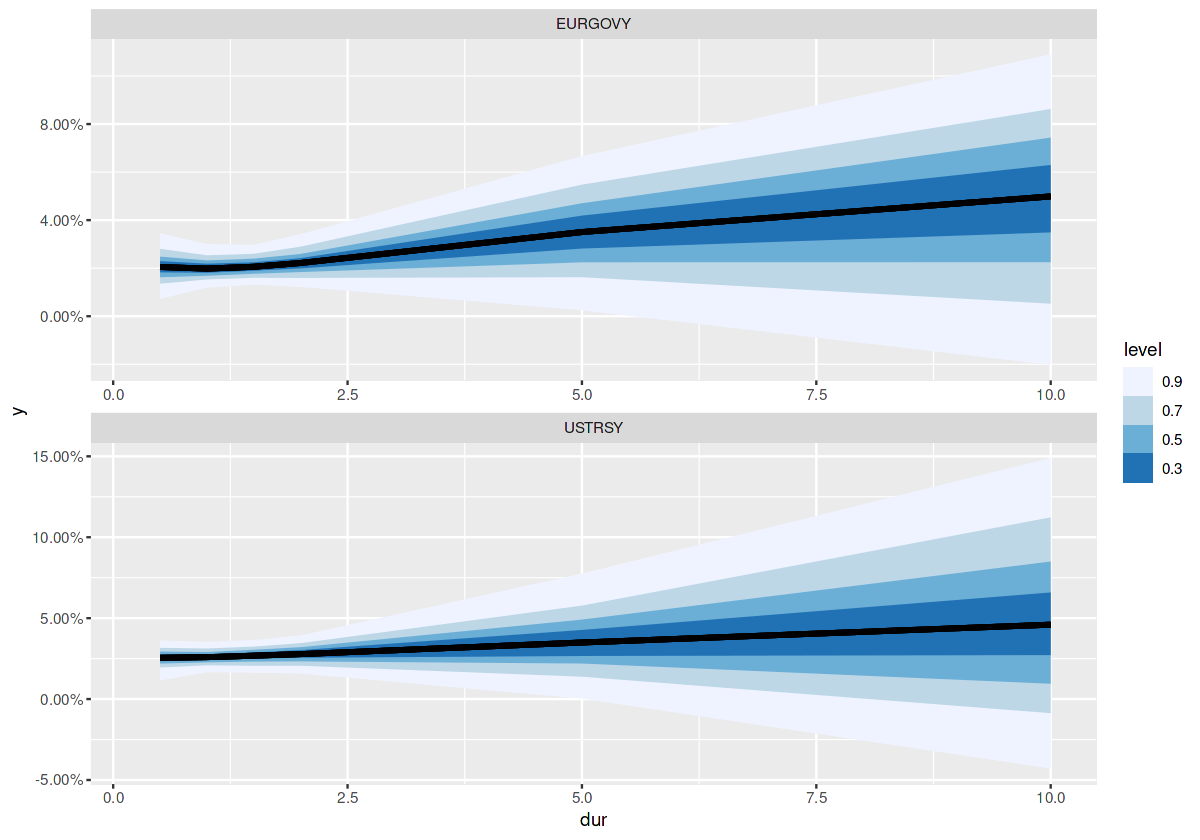

In [29]:
simresults$ahead$ycsims_close_tidy |> filter(period == "T+36") |> 
    mutate(y = y / 100) |> plot_lineribbon(quantiles, xlim = c(0.25, 10))
simresults$ahead$total_rets_cumul_tidy |> filter(period == "T+36") |>
    mutate(y = (1 + y)^(1 / 3) - 1) |> plot_lineribbon(quantiles, xlim = c(0.25, 10))

## Loading ML timeseries model (from Python Darts package) simulation $\beta$-s data

In [30]:
rawmldata <- vroom::vroom("../input/yield-curve-factor-forecasting-darts-ml/mybetas_ml_ts.csv")

Rows: 59200 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): model, component
dbl  (2): sample, value
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [31]:
mldata <- rawmldata |>
  filter(model == "lgbm") |>
  group_by(model, sample) |>
  group_split(.keep = FALSE) |>
  purrr::map(~ tidyr::pivot_wider(.x, id_cols = Date, names_from = component, values_from = value) |>
    xts::as.xts() |>
    as.matrix())

In [32]:
tictoc::tic()
with(simresults$lgbm, {
    betasims <- mldata
    ycsims_open <- betasims |> lapply(\(.x)head(.x, -1) |> msv_beta2zero(durs = durs, taus = taus))
    ycsims_close <- betasims |> lapply(\(.x, durs_)tail(.x, -1) |> msv_beta2zero(durs = durs_, taus = taus), durs_ = lapply(durs, \(d)d - 1 / 12))

    px_open <- ycsims_open |> lapply(zero2px, durs = durs)
    px_close <- ycsims_close |> lapply(zero2px, durs = lapply(durs, \(d)d - 1 / 12))

    total_rets <- tot_rets(px_open, px_close)
    total_rets_cumul <- tot_rets_cumul(total_rets)
    
    ycsims_close_tidy <- tidy_simulations(ycsims_close)
    total_rets_cumul_tidy <- tidy_simulations(total_rets_cumul)
})
tictoc::toc()

0.819 sec elapsed


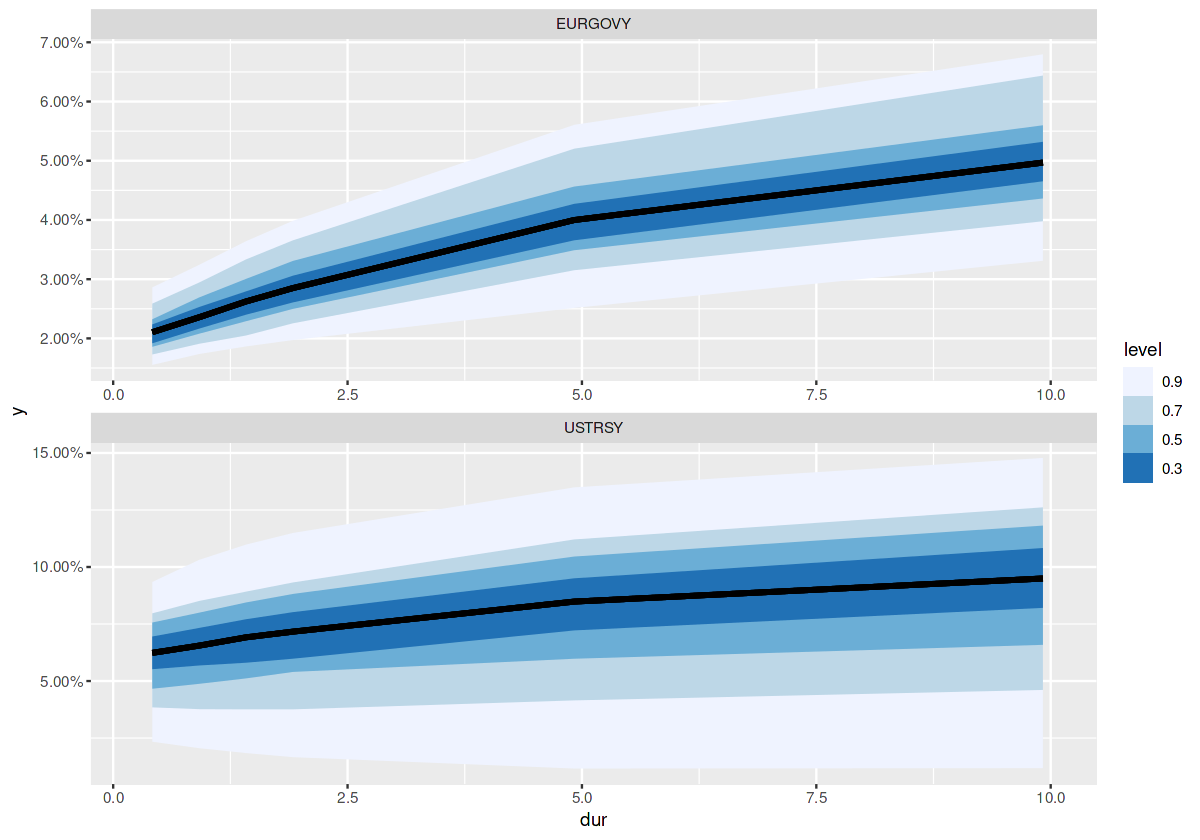

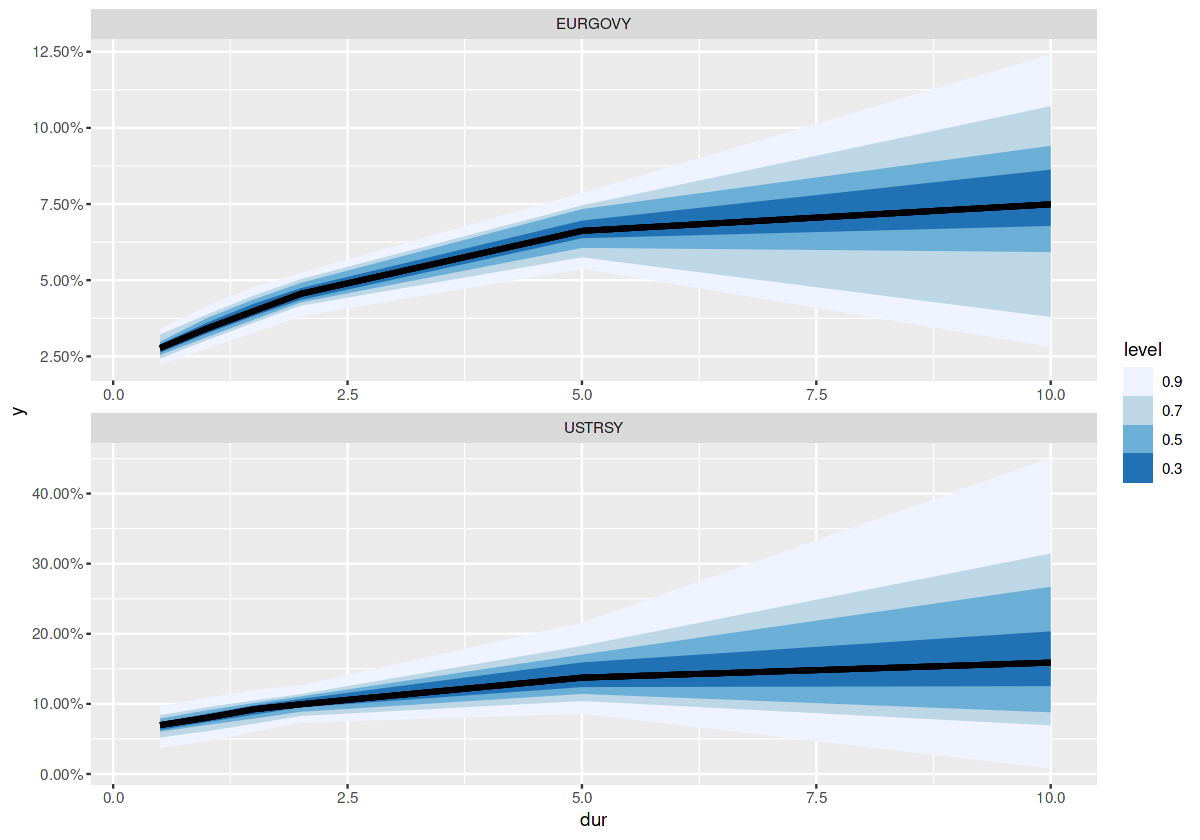

In [33]:
simresults$lgbm$ycsims_close_tidy |> filter(period == "2028-01-01") |>
    mutate(y = y / 100) |> plot_lineribbon(quantiles, xlim = c(0.25, 10))
simresults$lgbm$total_rets_cumul_tidy |> filter(period == "2028-01-01") |>
    mutate(y = (1 + y)^(1 / 3) - 1) |> plot_lineribbon(quantiles, xlim = c(0.25, 10))

In [34]:
save.image("results.RData")